<b><br>This notebook is going to implement this paper:</br>
<br>https://arxiv.org/pdf/1801.03018.pdf</br></b>
<br></br>
<br>Here is the first work flow, which uses the real world data (JPYUSD from 2010 to 2011) and uses Matplotlib for visualizing. Source of data:</br>
<br>https://www.histdata.com</br>
<br>The model used in this notebook is AlexNet (https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)</br>

In [1]:
#importing libraries
import pandas as pd
import numpy as np
from glob import glob as gb
from matplotlib import pyplot as plt
from matplotlib import patches as ptc
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras.utils import plot_model
from keras_preprocessing.image import ImageDataGenerator

In [4]:
#paramters
data_path = './data'

In [3]:
#first, loading and resampling data from the csv file to be daily
list_of_files = [i for i in gb('data/*.xlsx')]
data = []
for i in list_of_files:
    a = pd.read_excel(i,
                      header = None,
                      index_col = 0)
    a.index = pd.to_datetime(a.index)
    data.append(a)
data = data[1][1]
data = data.resample('D').bfill()
data = pd.DataFrame(data)
data.head()

1
0                
2011-01-02  81.22
2011-01-03  81.25
2011-01-04  82.11
2011-01-05  81.94
2011-01-06  83.24

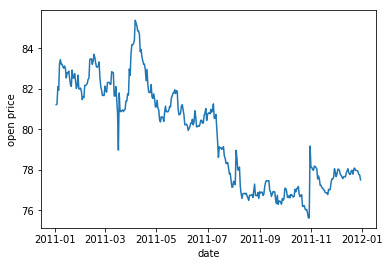

In [4]:
#visualizing the data
x_ = data.index
plt.plot(x_,data[1])
plt.xlabel('date')
plt.ylabel('open price')
plt.show()

In [5]:
#convert the data to visual pics using matplotlib
def data_vis(df,inv=True):
    '''
    visualizes a DataFrame, which can have price data or indexes. Then gives the numpy ndarray
    for that image.
    
    Args:
        df (pandas dataframe): dataframe containing price data and indicators data.
        inv (bool): If true, then the colors of the picture will be inverted.
        
    Returns:
        numpy ndarray, representing numerical data of the image.
    '''
    fig, ax = plt.subplots(figsize=(10, 15))
    fig.set_dpi(150)
    for i in df.keys():
        ax.plot(list(range(len(df.index))),df[i])
    fig.canvas.draw()
    data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    if inv:
        data = abs(data-255)
    return data
    

In [6]:
#create MA lines
def pd_ma(price,ma):
    '''
    Uses data frame of prices (could be OHLC or just one, two or three series of prices) to
    calculate simple moving averages.
    
    Args:
        price(pandas dataframe): dataframe containing price data.
        ma(list of ints): list, containing the moving average parameters.
        
    Returns:
        pandas dataframe, containing original price data and moving average columns. 
    '''
    ma_data = price
    assert type(ma)==list;
    assert type(price)==pd.core.frame.DataFrame
    for i in ma:
        assert type(i) == int;
        assert i<len(price)
        for j in price.keys():
            name_str = 'ma'+str(j)+'_'+str(i)
            ma_ = price[j].rolling(i).mean()
            ma_df = pd.DataFrame(data=ma_.values,
                                 columns=[name_str],
                                 index=ma_.index)
            ma_data = pd.concat([ma_data,ma_df],
                                axis = 1)
    return ma_data

In [7]:
#building model, from https://github.com/eweill/keras-deepcv/blob/master/models/classification/alexnet.py:
def alexnet_model(img_shape=(100,150,3), n_classes=10, l2_reg=0.,weights=None):

    # Initialize model
    alexnet = Sequential()

    # Layer 1
    alexnet.add(Conv2D(96, (11, 11), input_shape=img_shape,
    padding='same', kernel_regularizer=l2(l2_reg)))
    alexnet.add(BatchNormalization())
    alexnet.add(Activation('relu'))
    alexnet.add(MaxPooling2D(pool_size=(2, 2)))

    # Layer 2
    alexnet.add(Conv2D(256, (5, 5), padding='same'))
    alexnet.add(BatchNormalization())
    alexnet.add(Activation('relu'))
    alexnet.add(MaxPooling2D(pool_size=(2, 2)))

    # Layer 3
    alexnet.add(ZeroPadding2D((1, 1)))
    alexnet.add(Conv2D(512, (3, 3), padding='same'))
    alexnet.add(BatchNormalization())
    alexnet.add(Activation('relu'))
    alexnet.add(MaxPooling2D(pool_size=(2, 2)))

    # Layer 4
    alexnet.add(ZeroPadding2D((1, 1)))
    alexnet.add(Conv2D(1024, (3, 3), padding='same'))
    alexnet.add(BatchNormalization())
    alexnet.add(Activation('relu'))

    # Layer 5
    alexnet.add(ZeroPadding2D((1, 1)))
    alexnet.add(Conv2D(1024, (3, 3), padding='same'))
    alexnet.add(BatchNormalization())
    alexnet.add(Activation('relu'))
    alexnet.add(MaxPooling2D(pool_size=(2, 2)))

    # Layer 6
    alexnet.add(Flatten())
    alexnet.add(Dense(3072))
    alexnet.add(BatchNormalization())
    alexnet.add(Activation('relu'))
    alexnet.add(Dropout(0.5))

    # Layer 7
    alexnet.add(Dense(4096))
    alexnet.add(BatchNormalization())
    alexnet.add(Activation('relu'))
    alexnet.add(Dropout(0.5))

    # Layer 8
    alexnet.add(Dense(n_classes))
    alexnet.add(BatchNormalization())
    alexnet.add(Activation('softmax'))

    if weights is not None:
        alexnet.load_weights(weights)

    return alexnet

In [8]:
#percent change calculator
def pct_chng(a,b):
    '''
    calculates diffrence in percent between two numbers.
    
    Args:
        a,b (float): numbers to calculate their percent change. "b" will be compared to "a".
        in other words, if b<a, then function will return a negative number. Otherwise, it will
        return a positive number.
    Returns:
        float, percent change from a to b.
    '''
    return float(((a-b)*100)/a)

In [9]:
#let's make the training data
ma_pars = [5,7,10,20]
data = pd_ma(data,ma_pars)
data = data.dropna(axis=0)
data.to_csv('data.csv')

In [10]:
#here, I will split the data into chunks
data = pd.read_csv('data.csv',index_col=0)
data = data.values
data_chs = []
for i in range(len(x_)-20):
    if i!=17:
        chunk = data[i:i+20,:]
    else:
        chunk = data[i:,:]
    data_chs.append(chunk)
del(data)

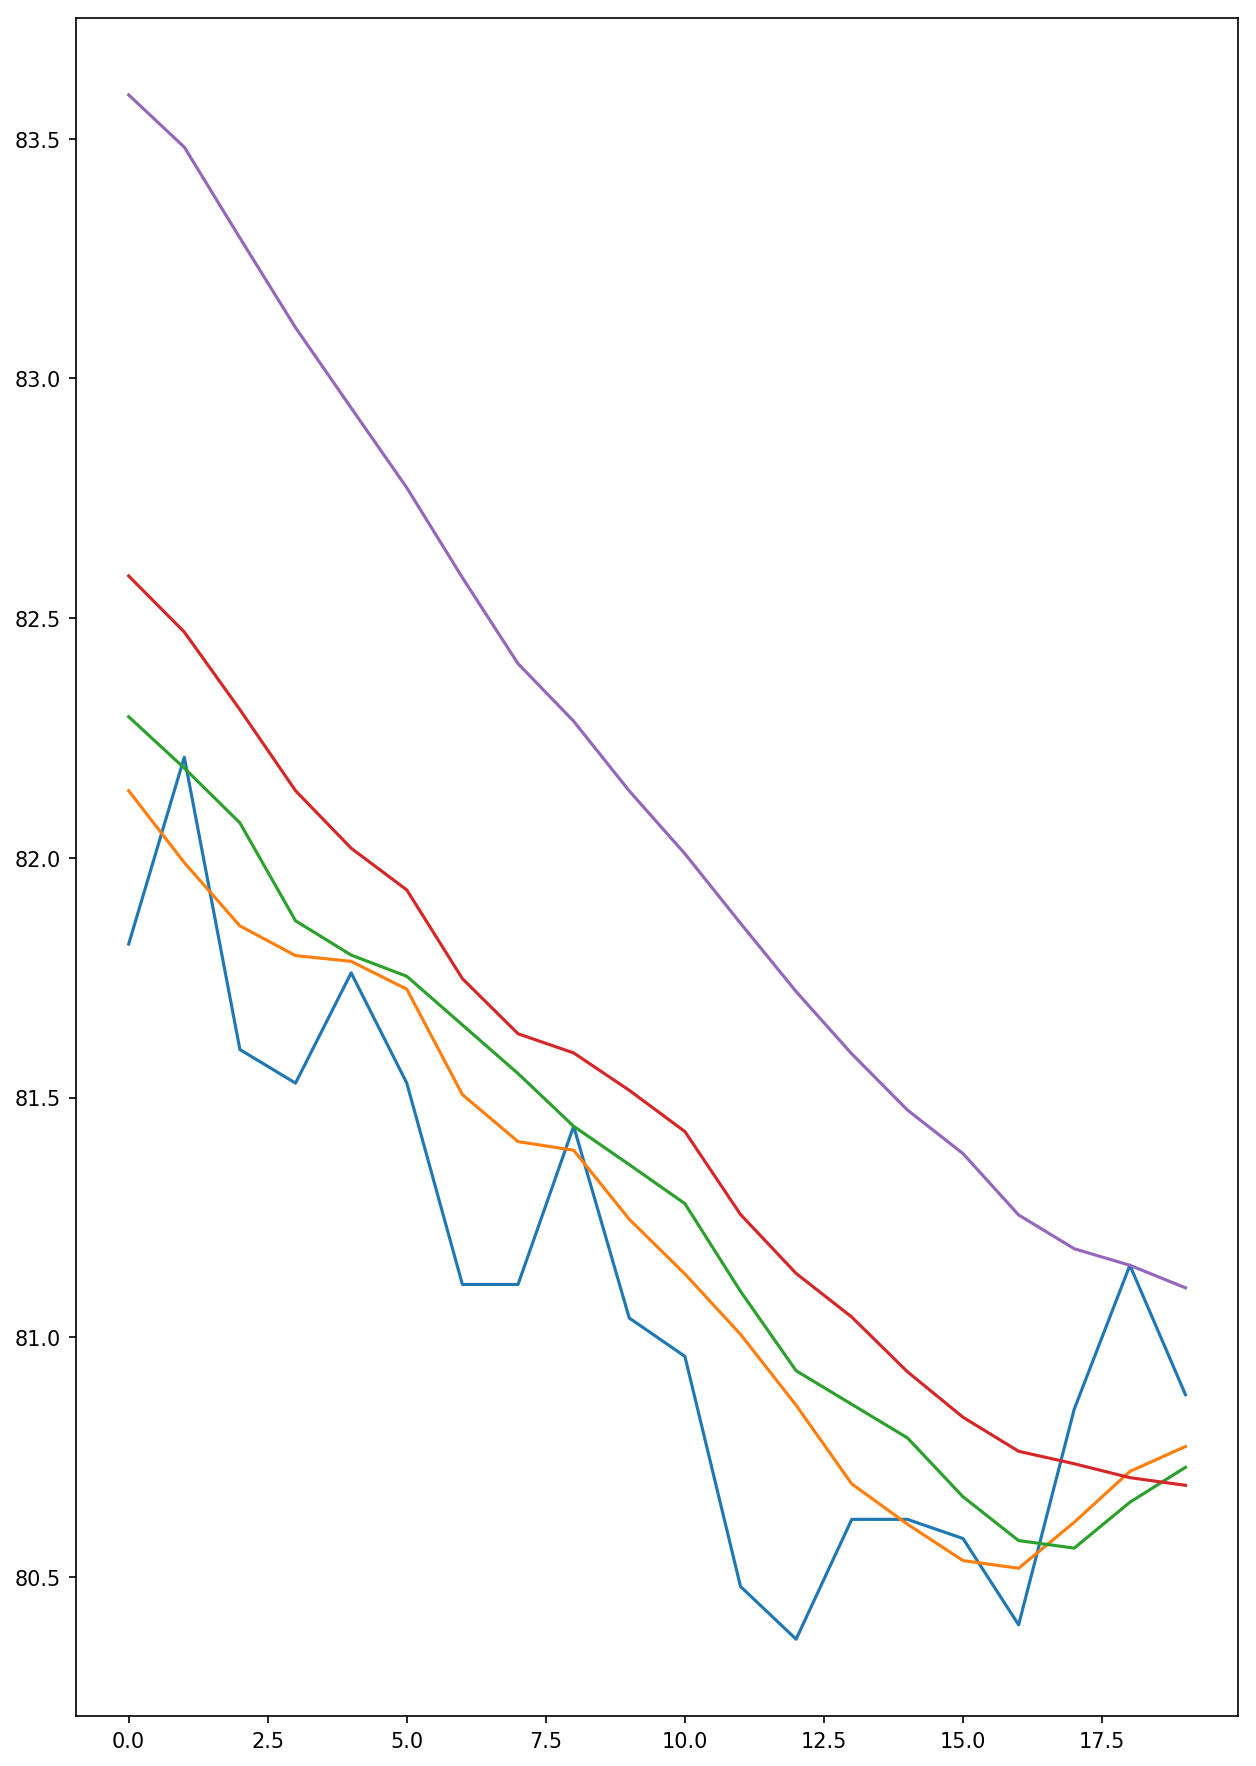

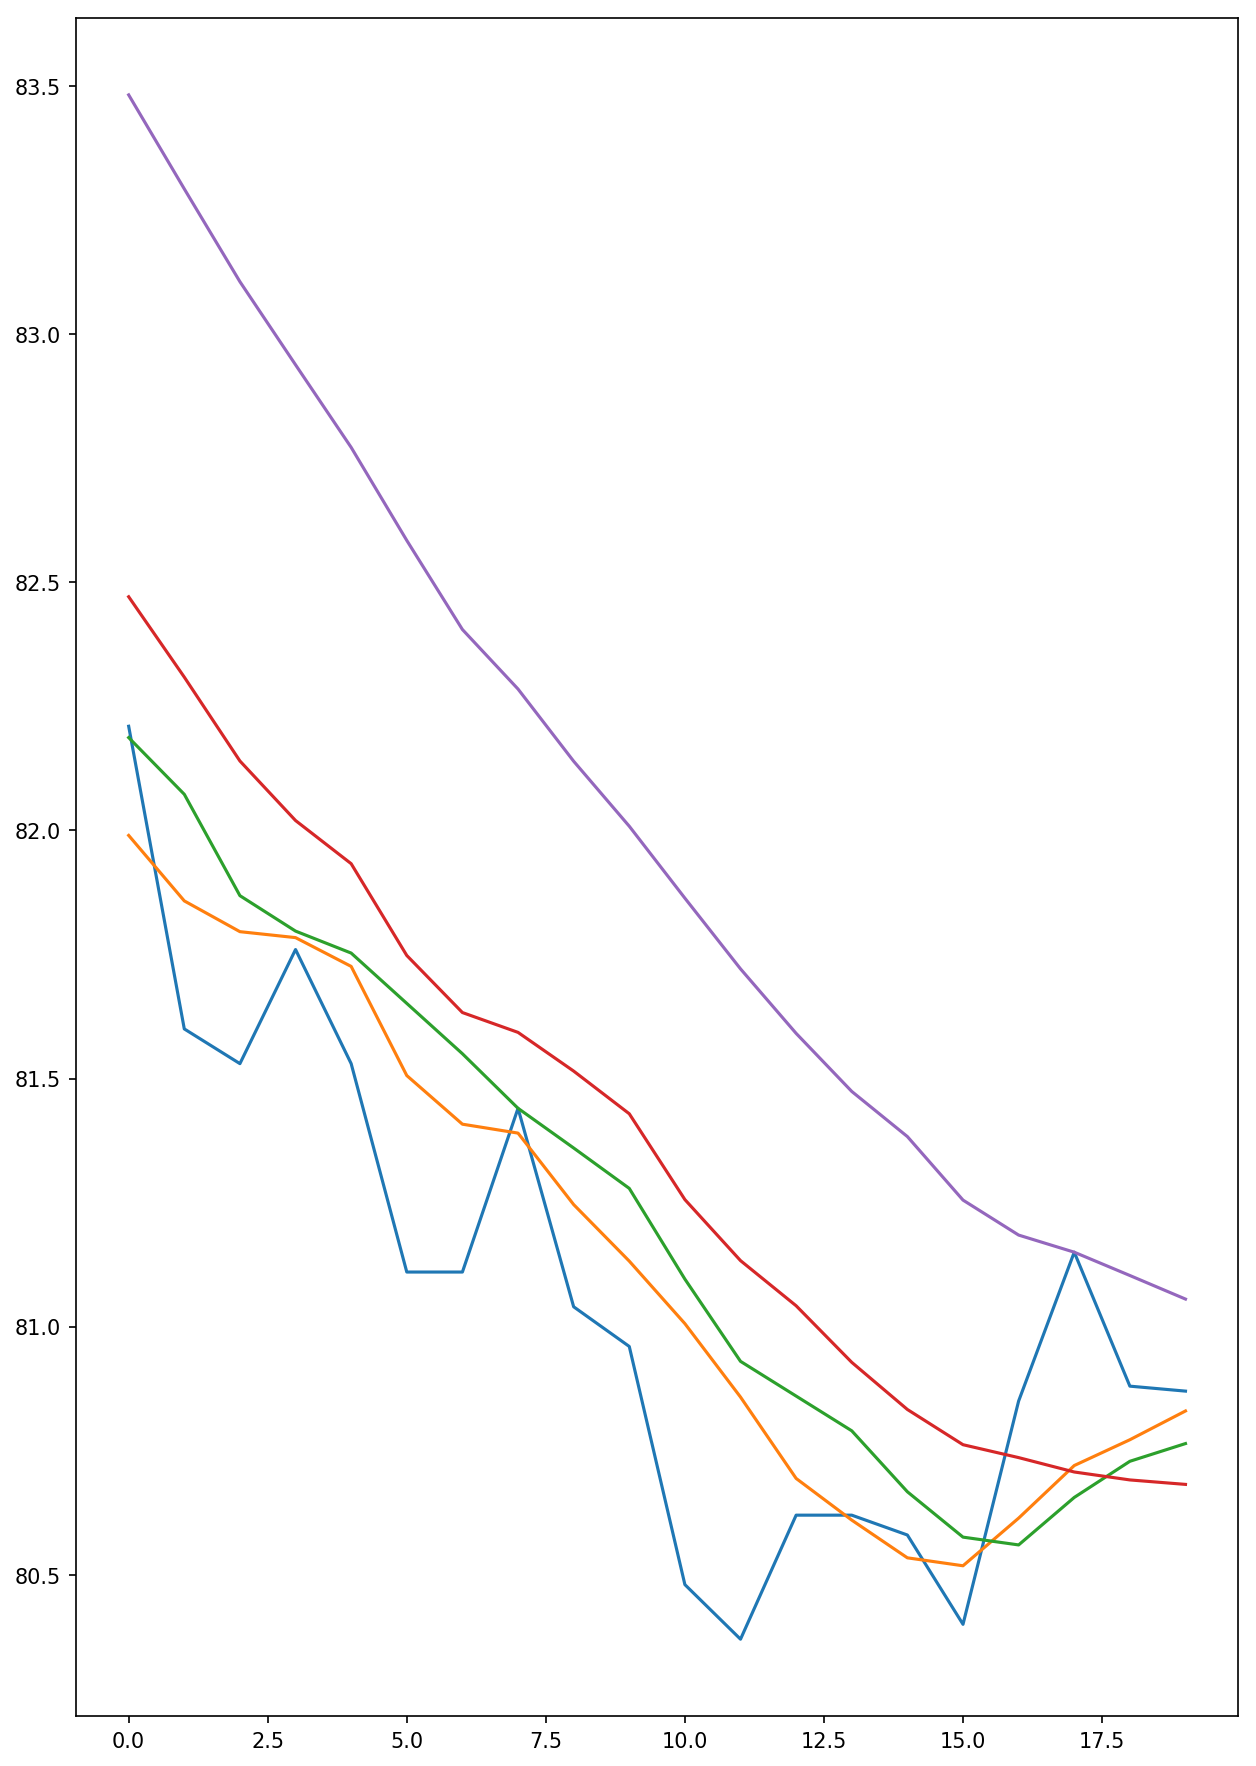

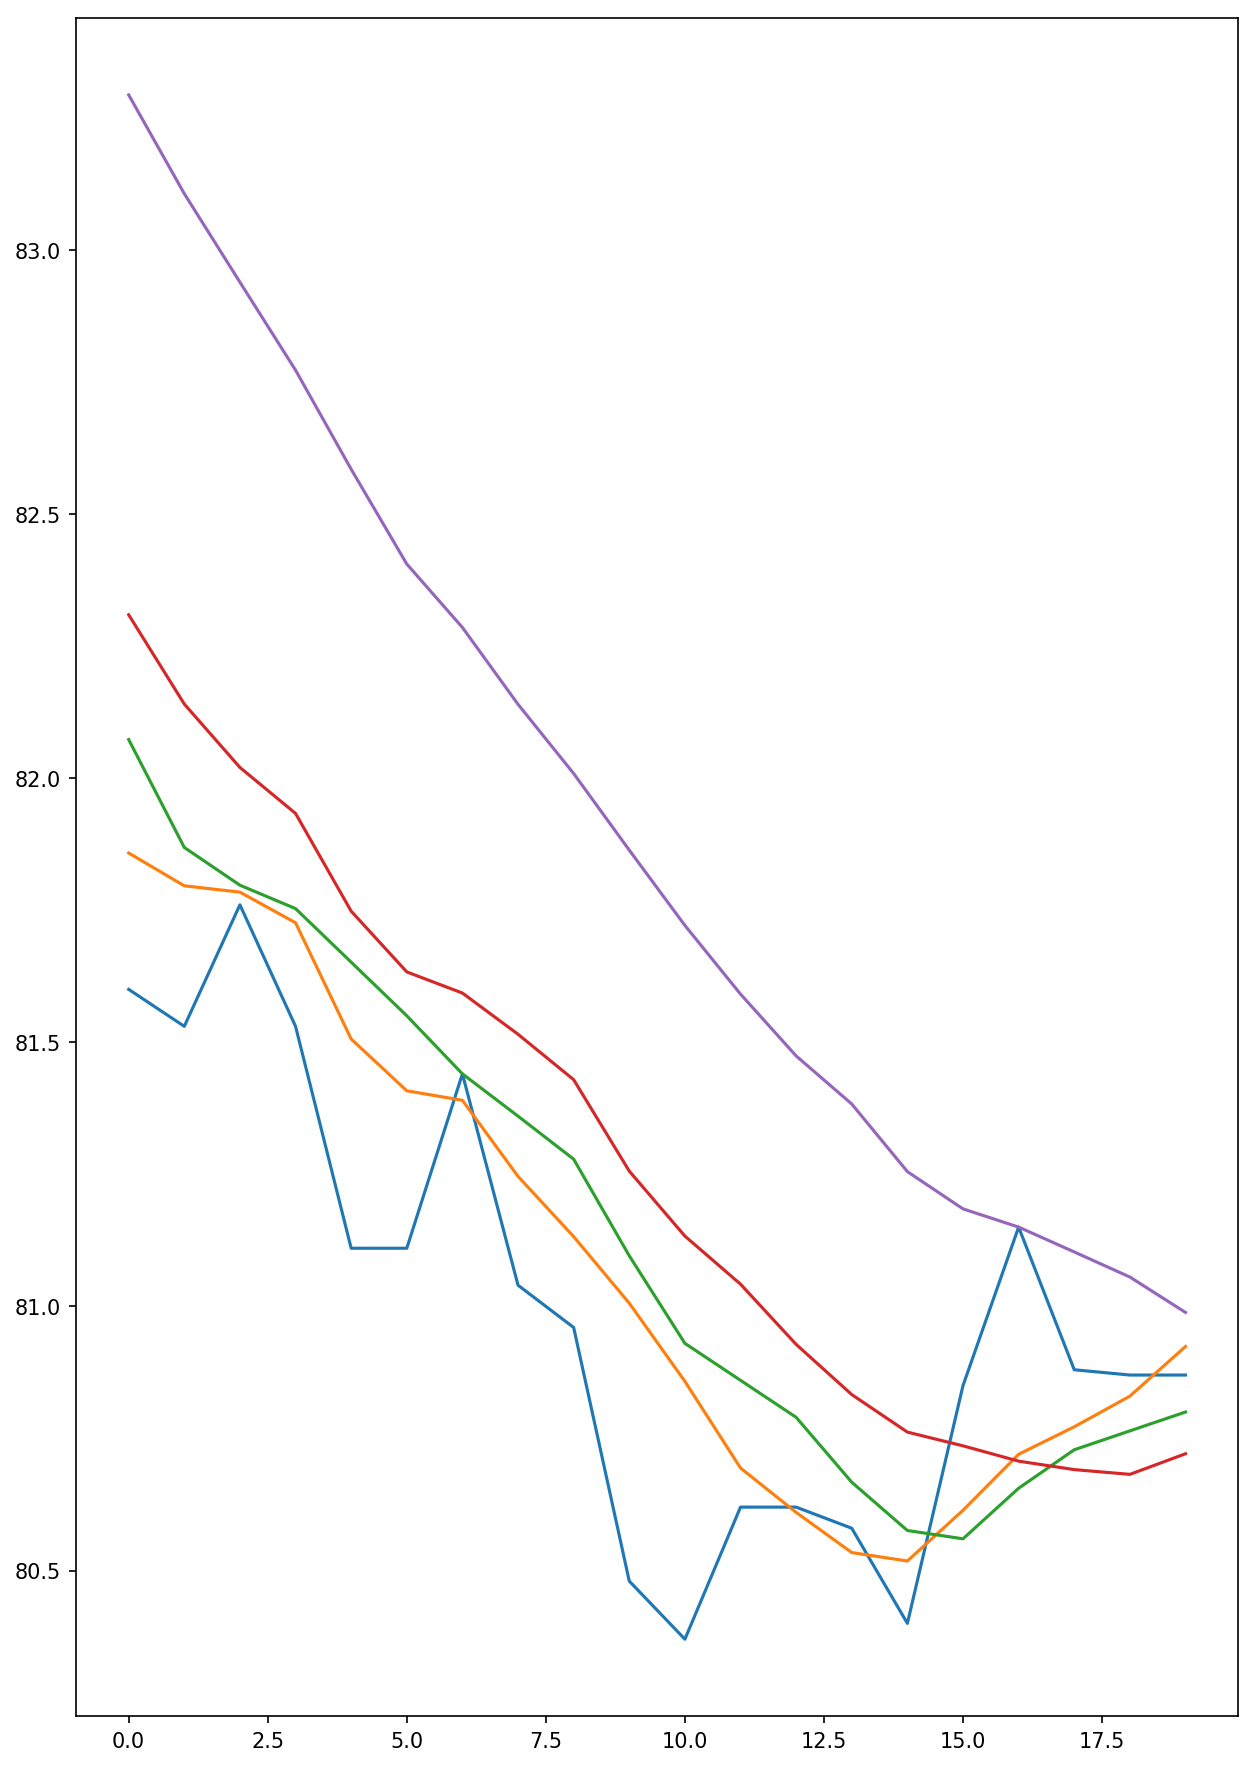

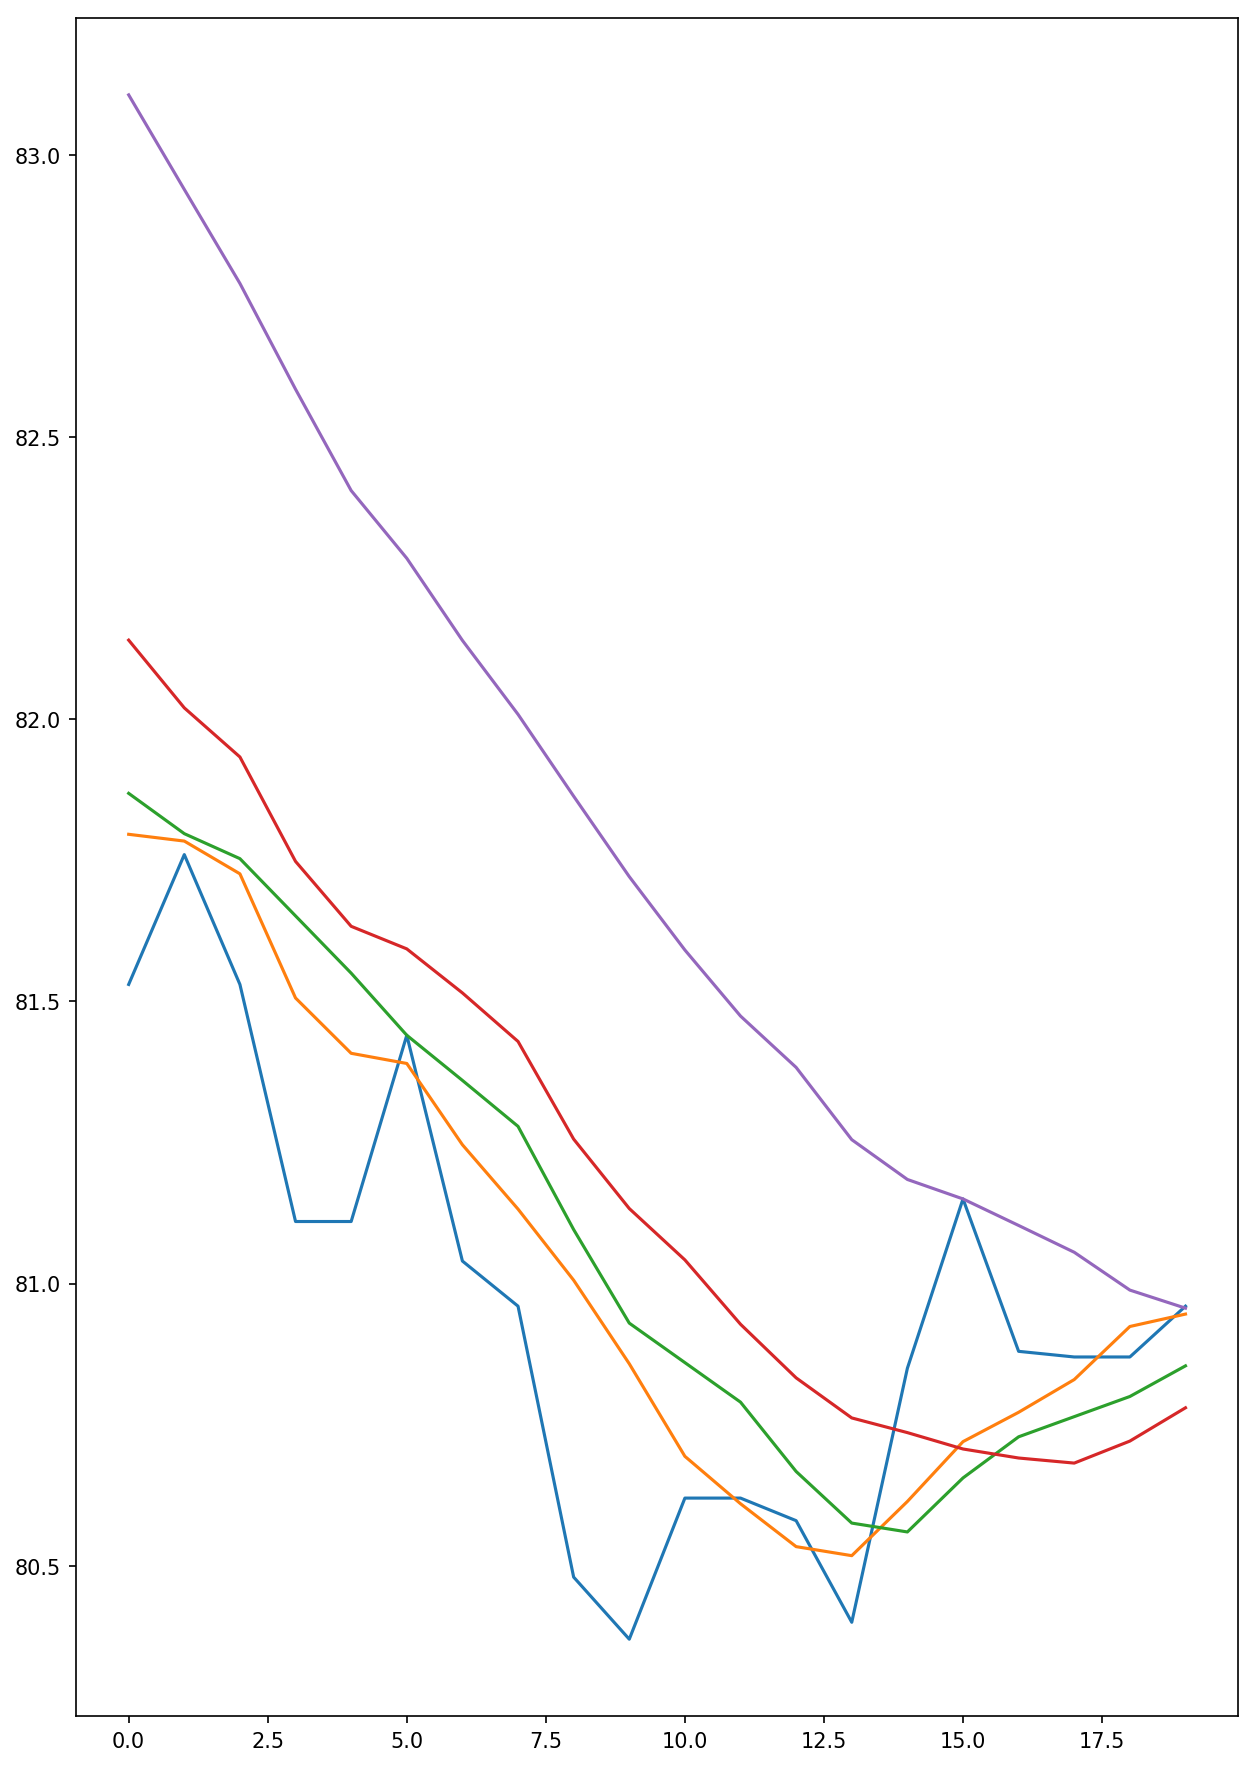

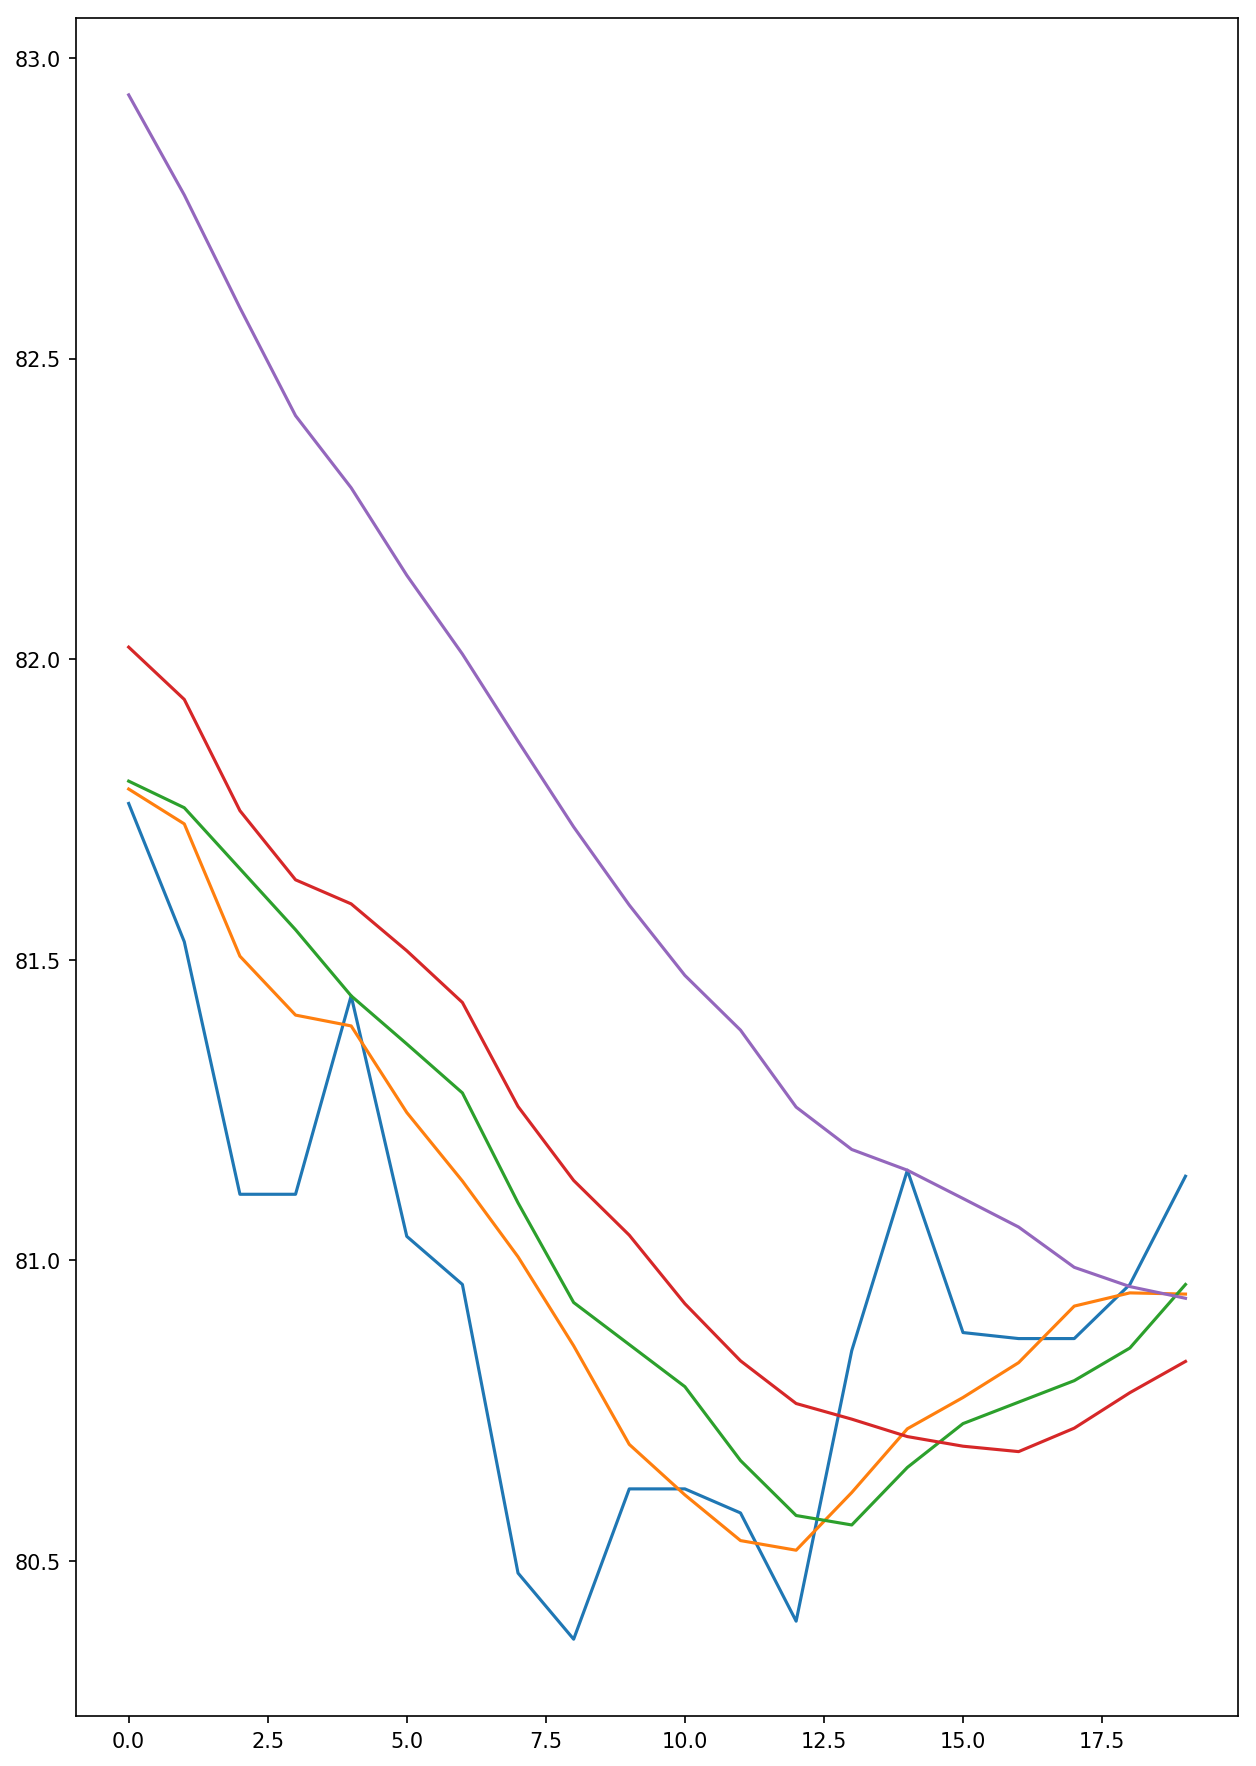

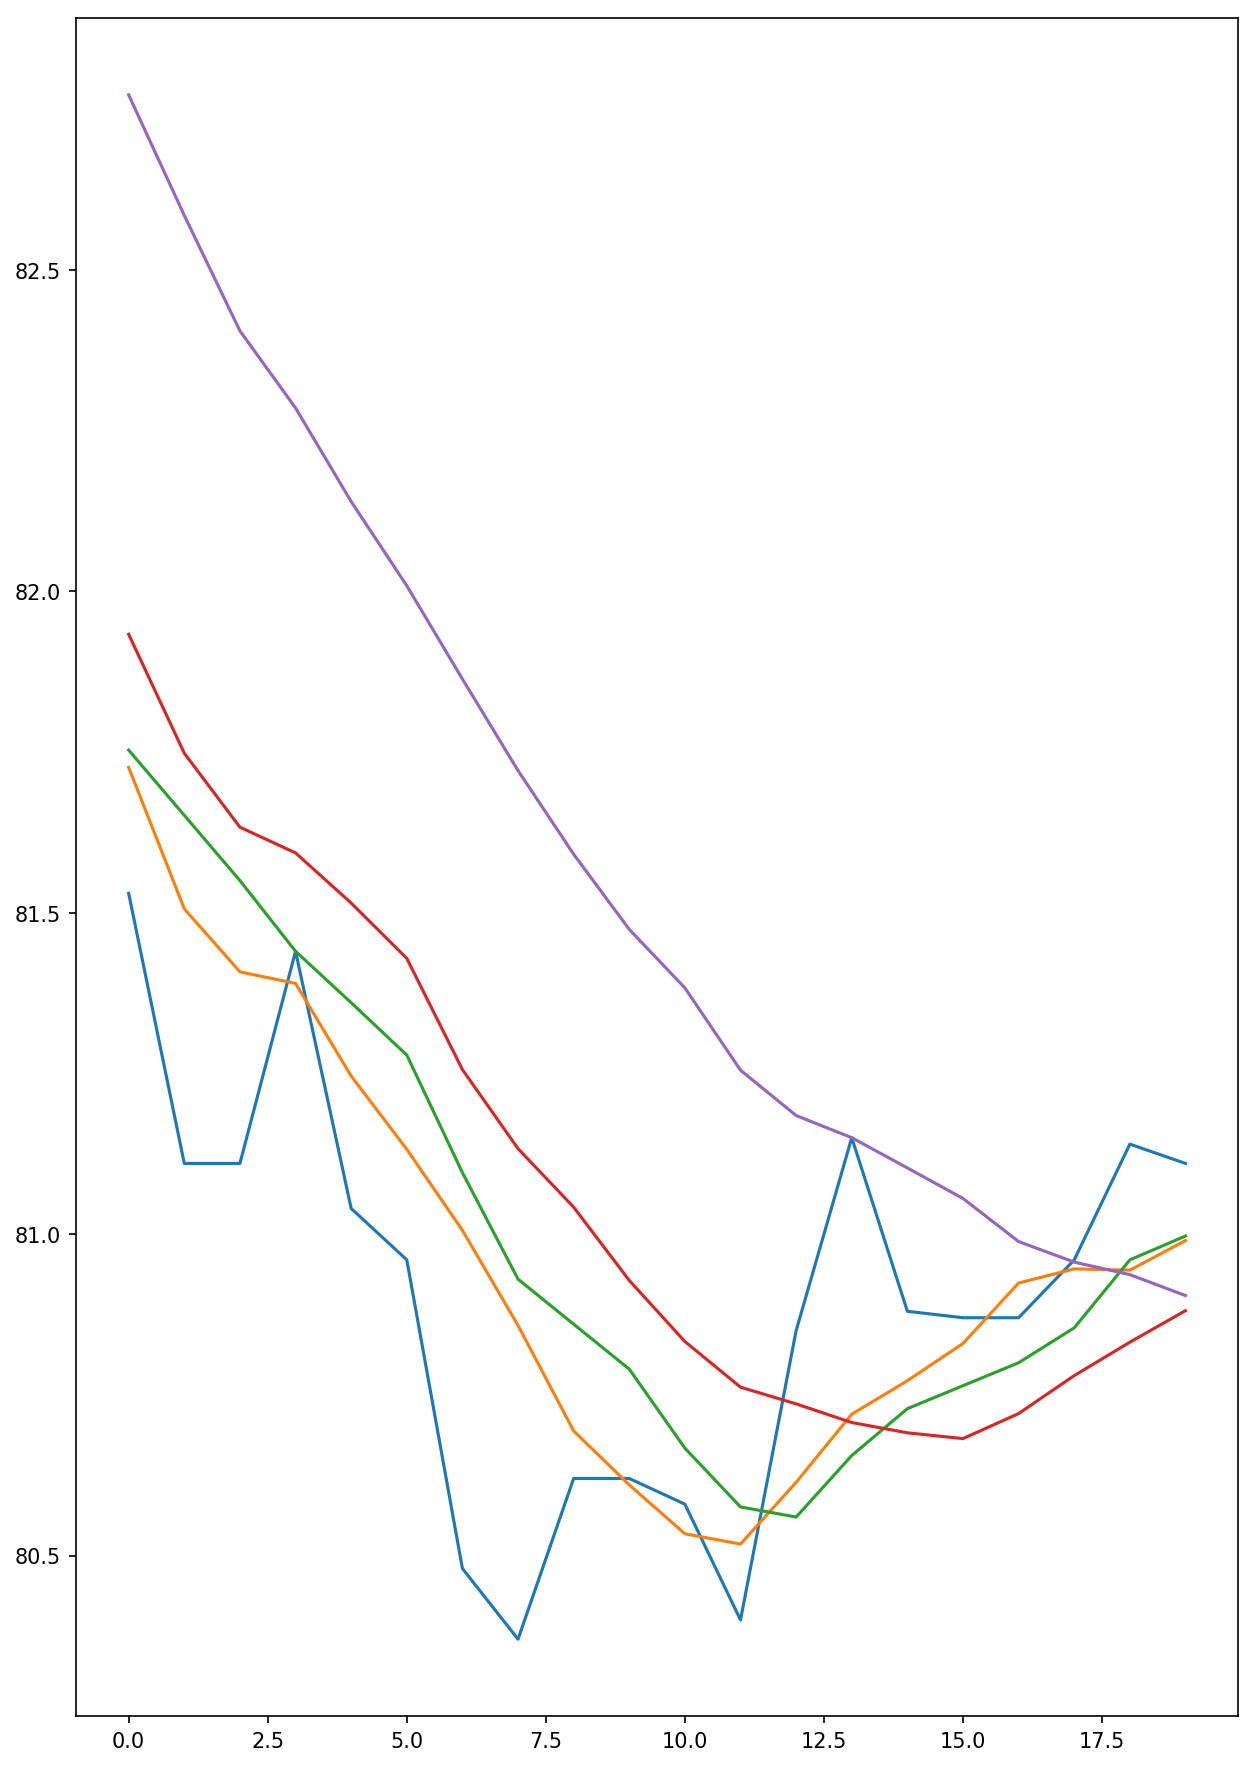

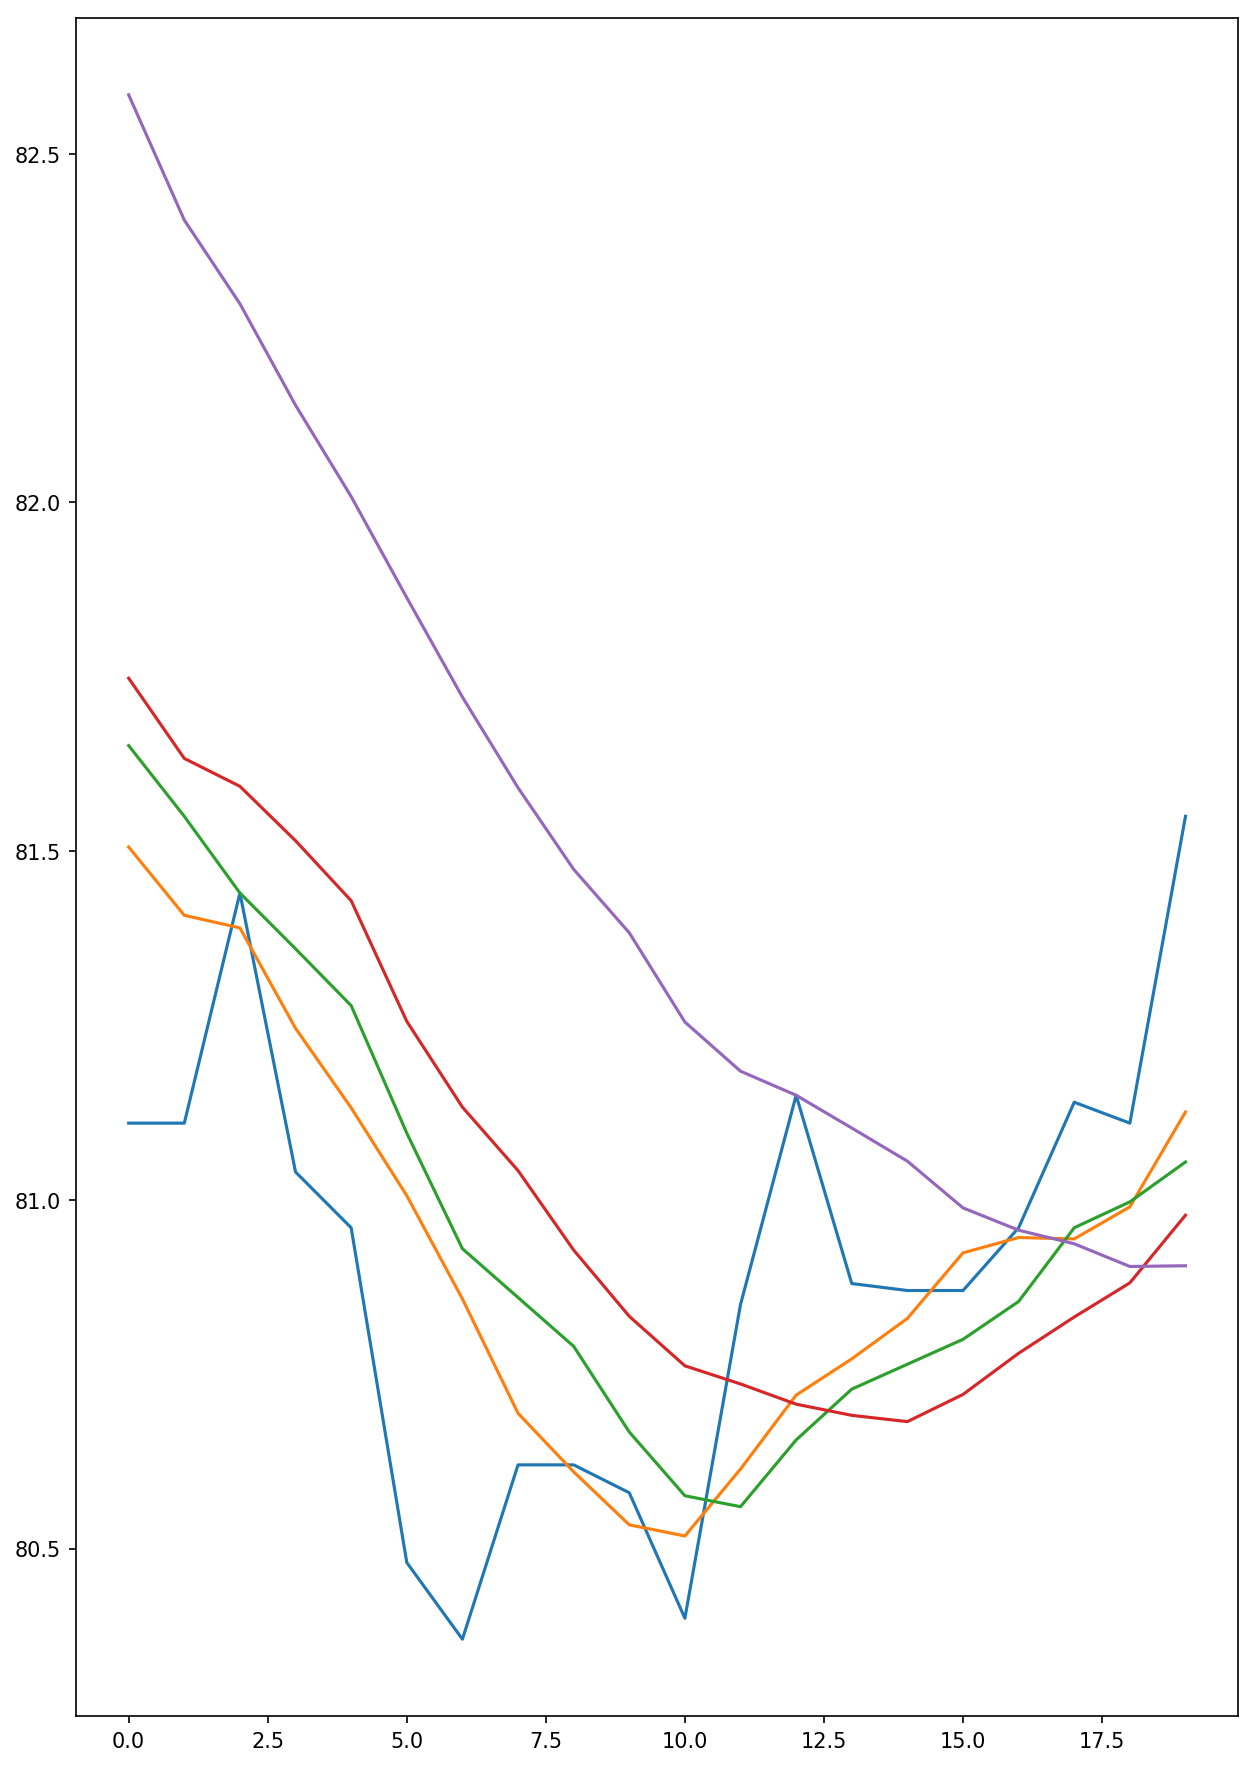

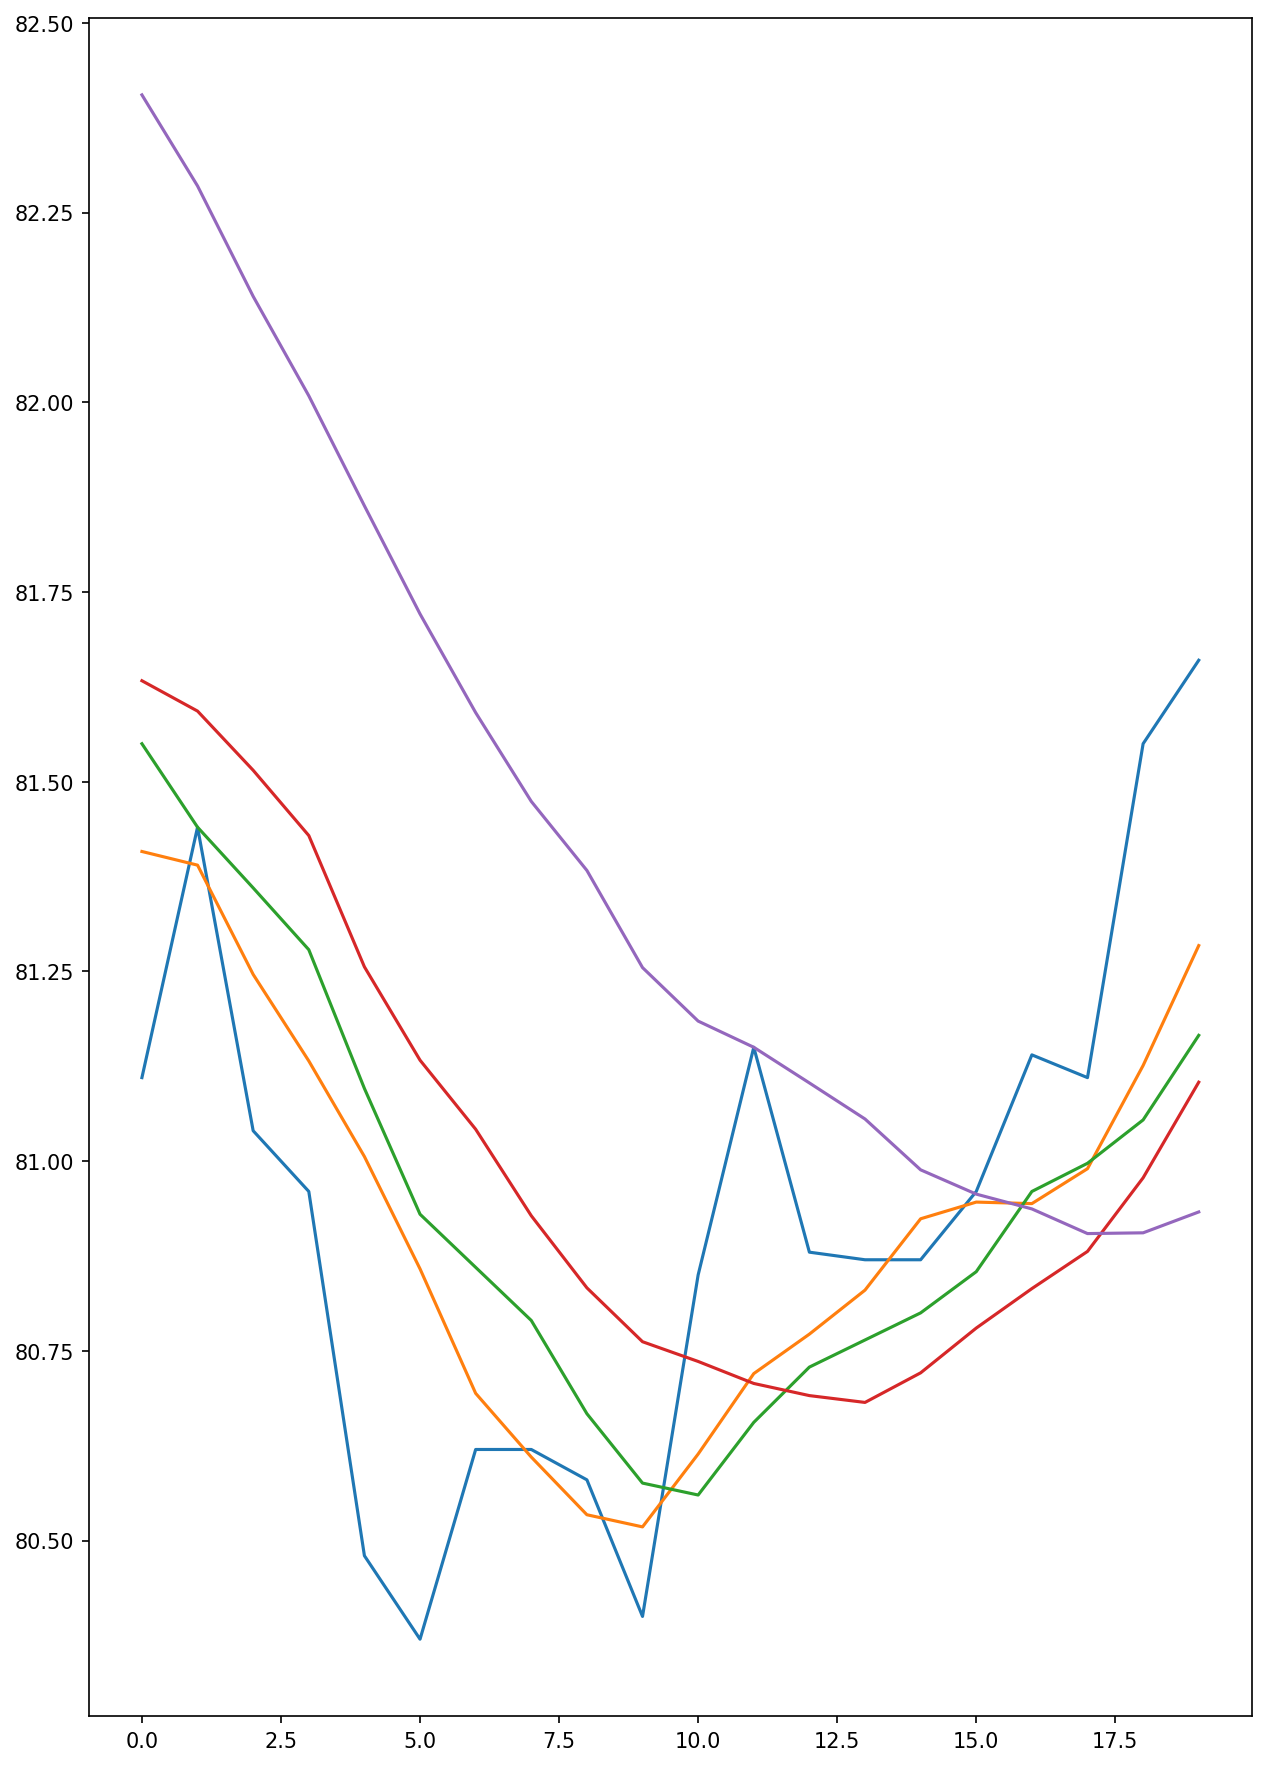

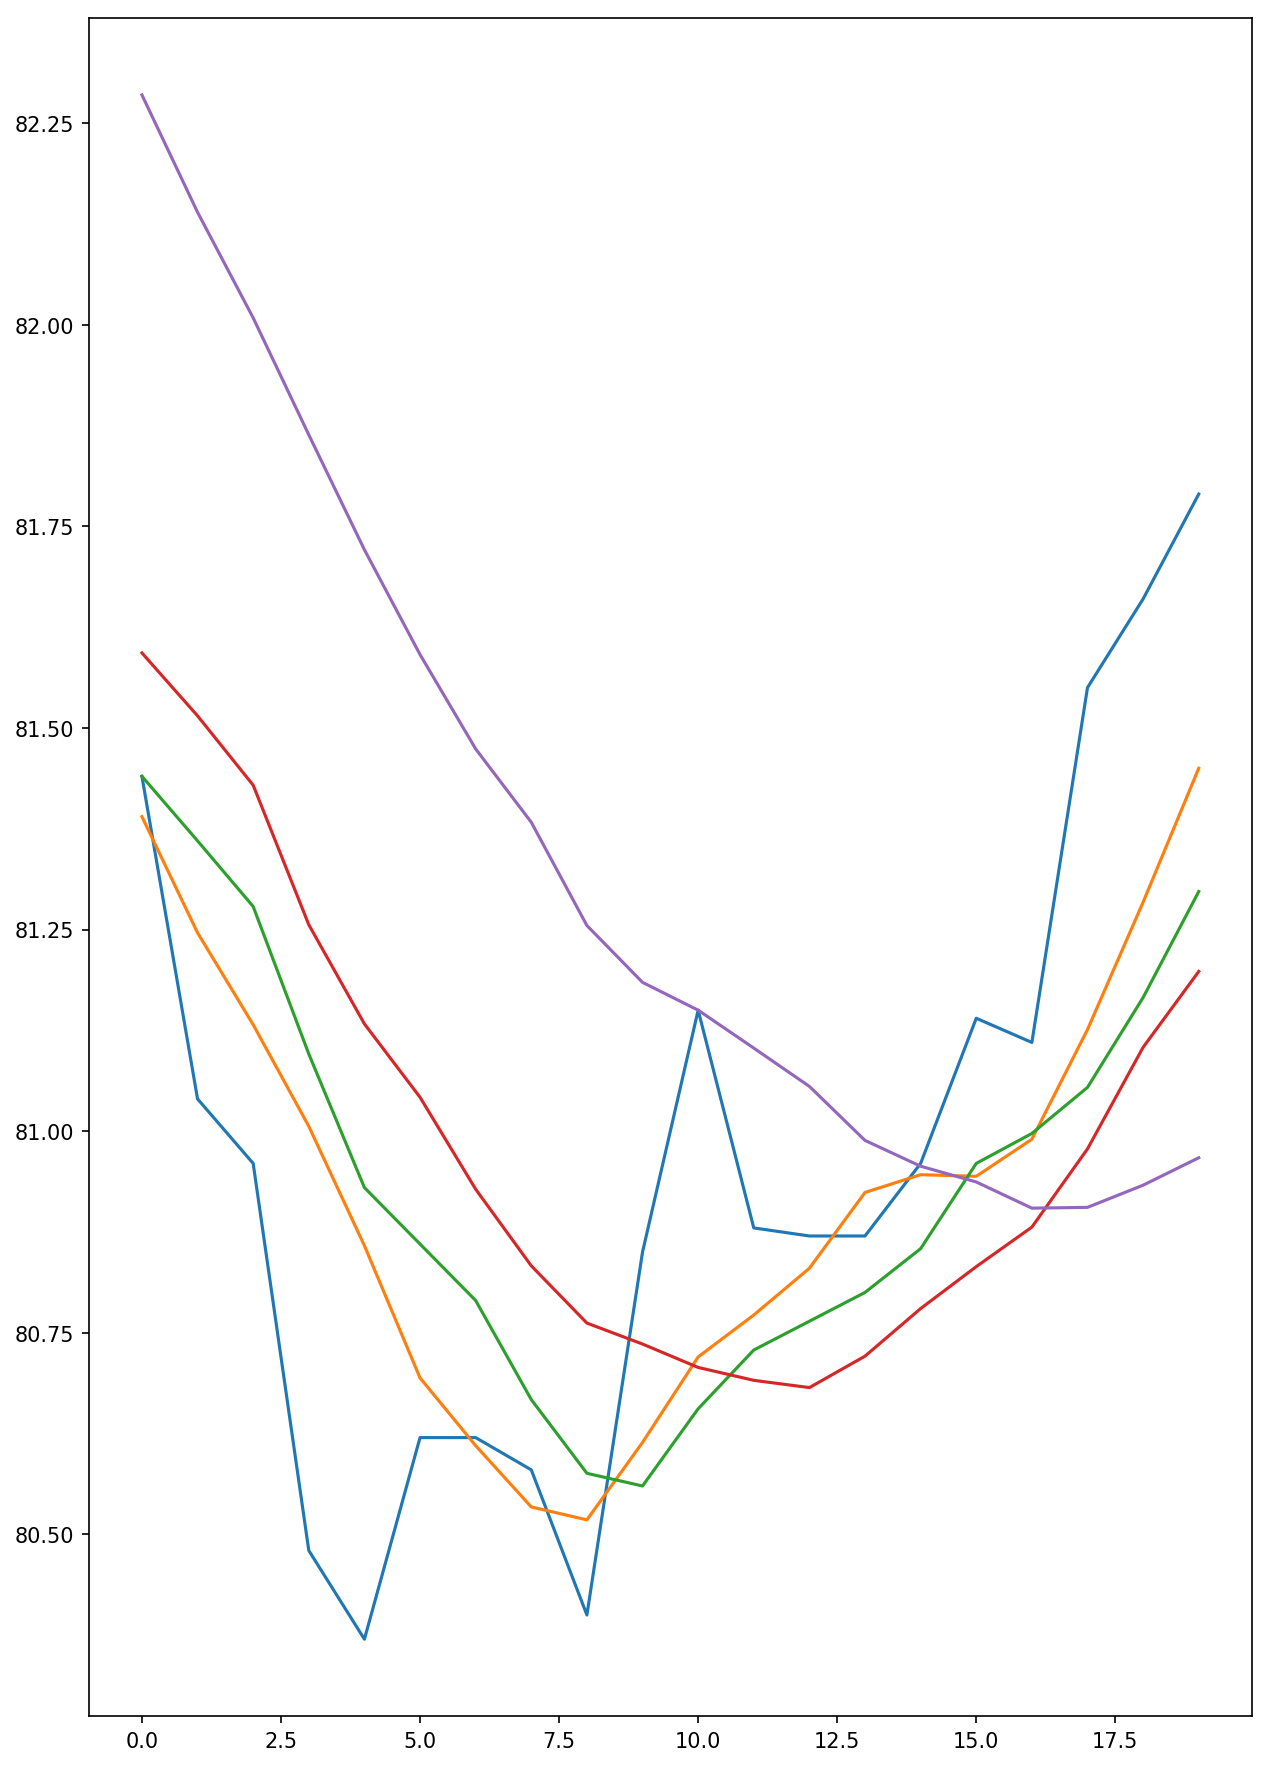

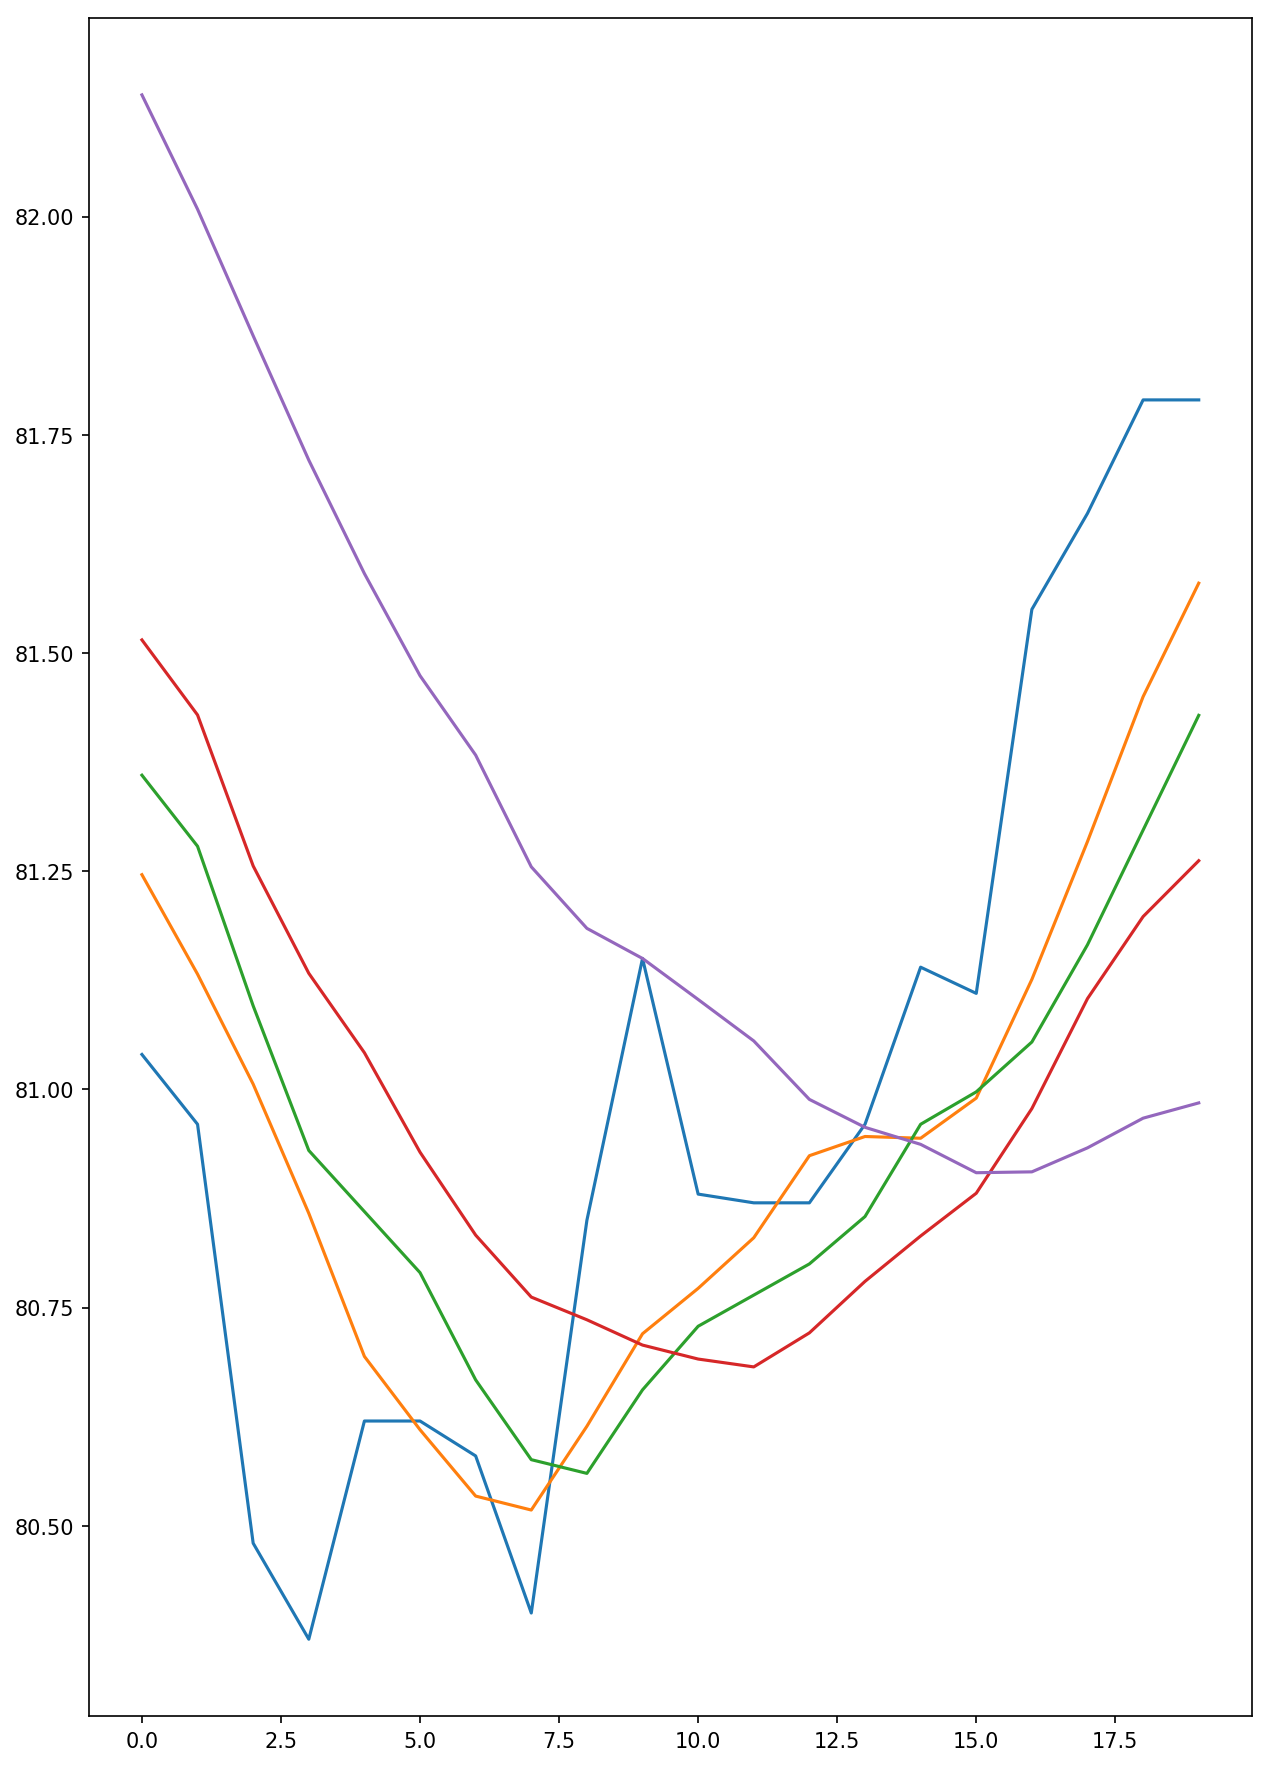

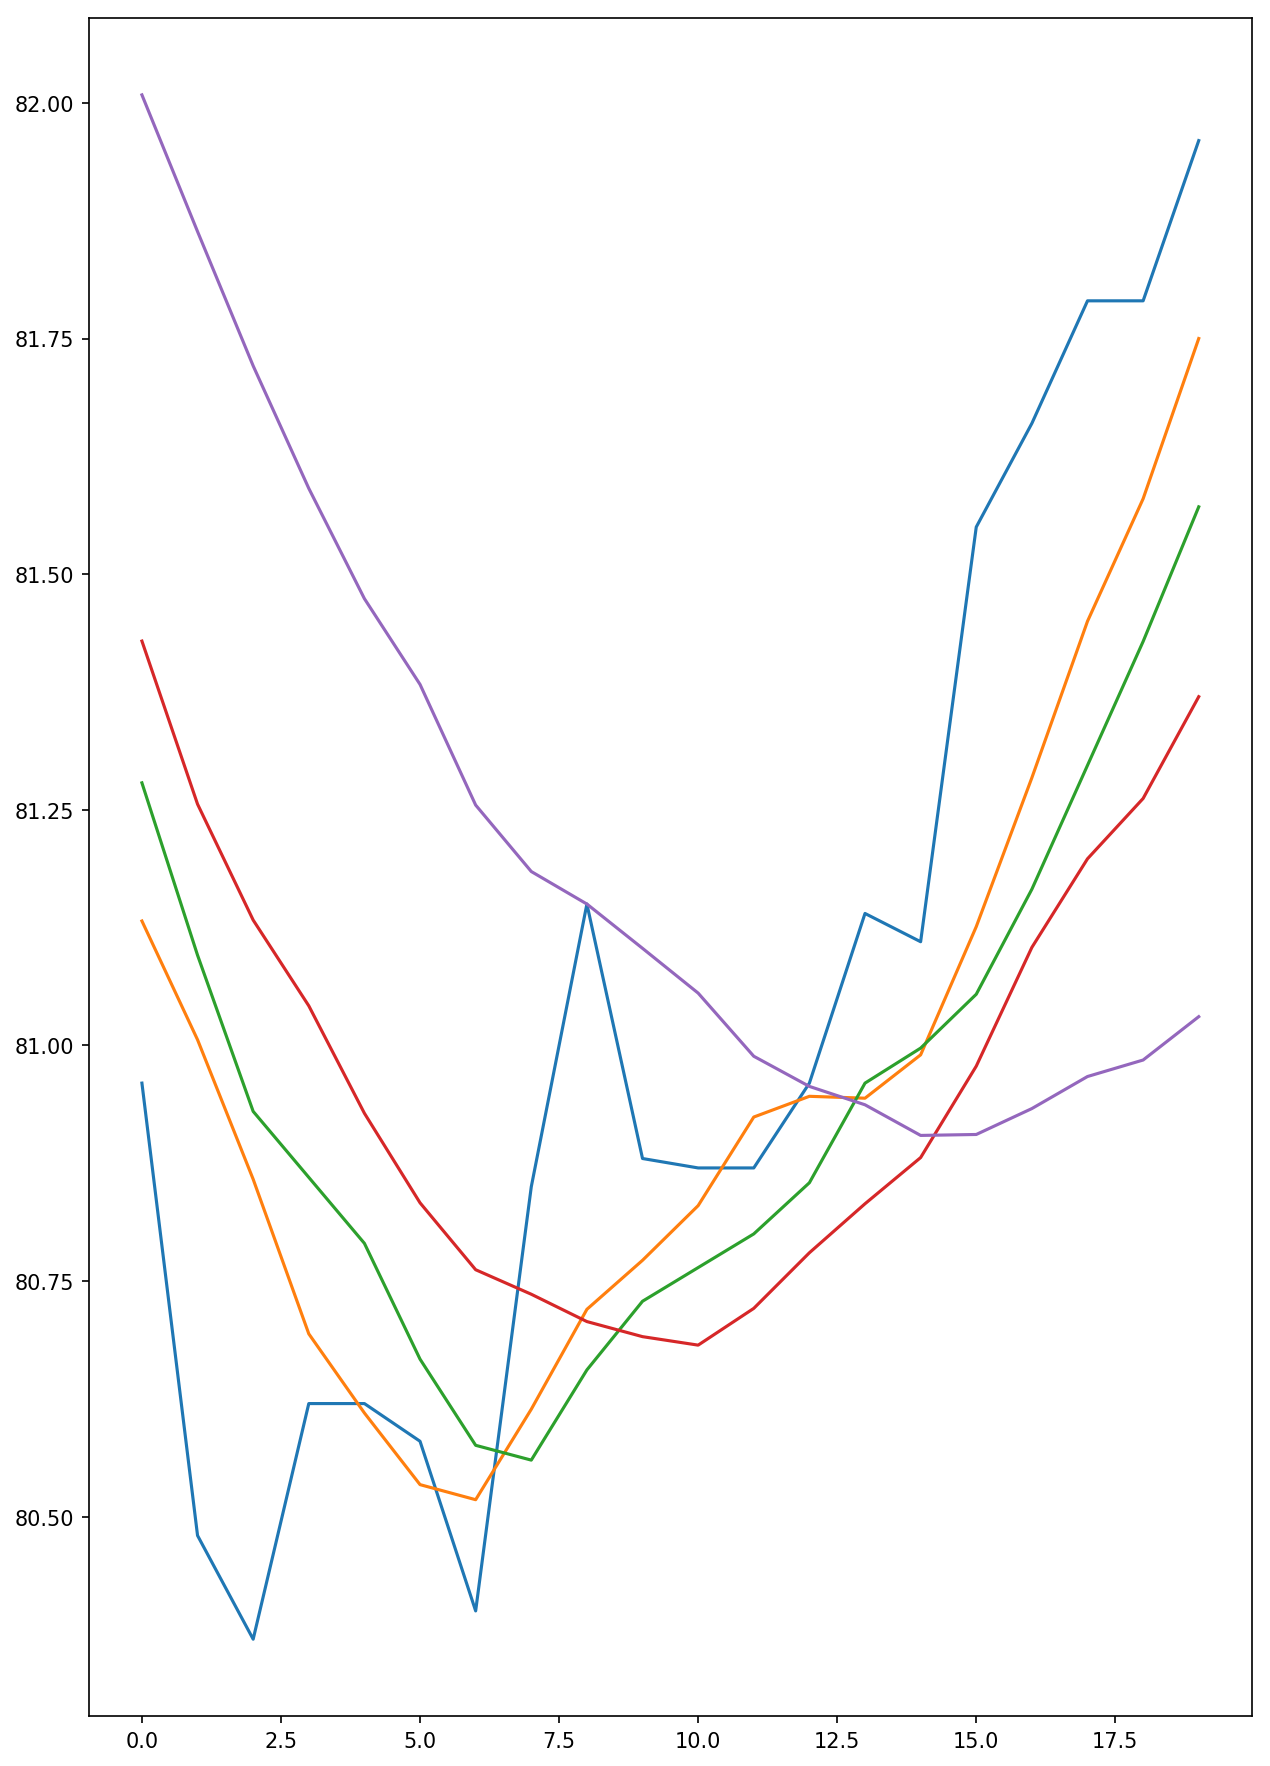

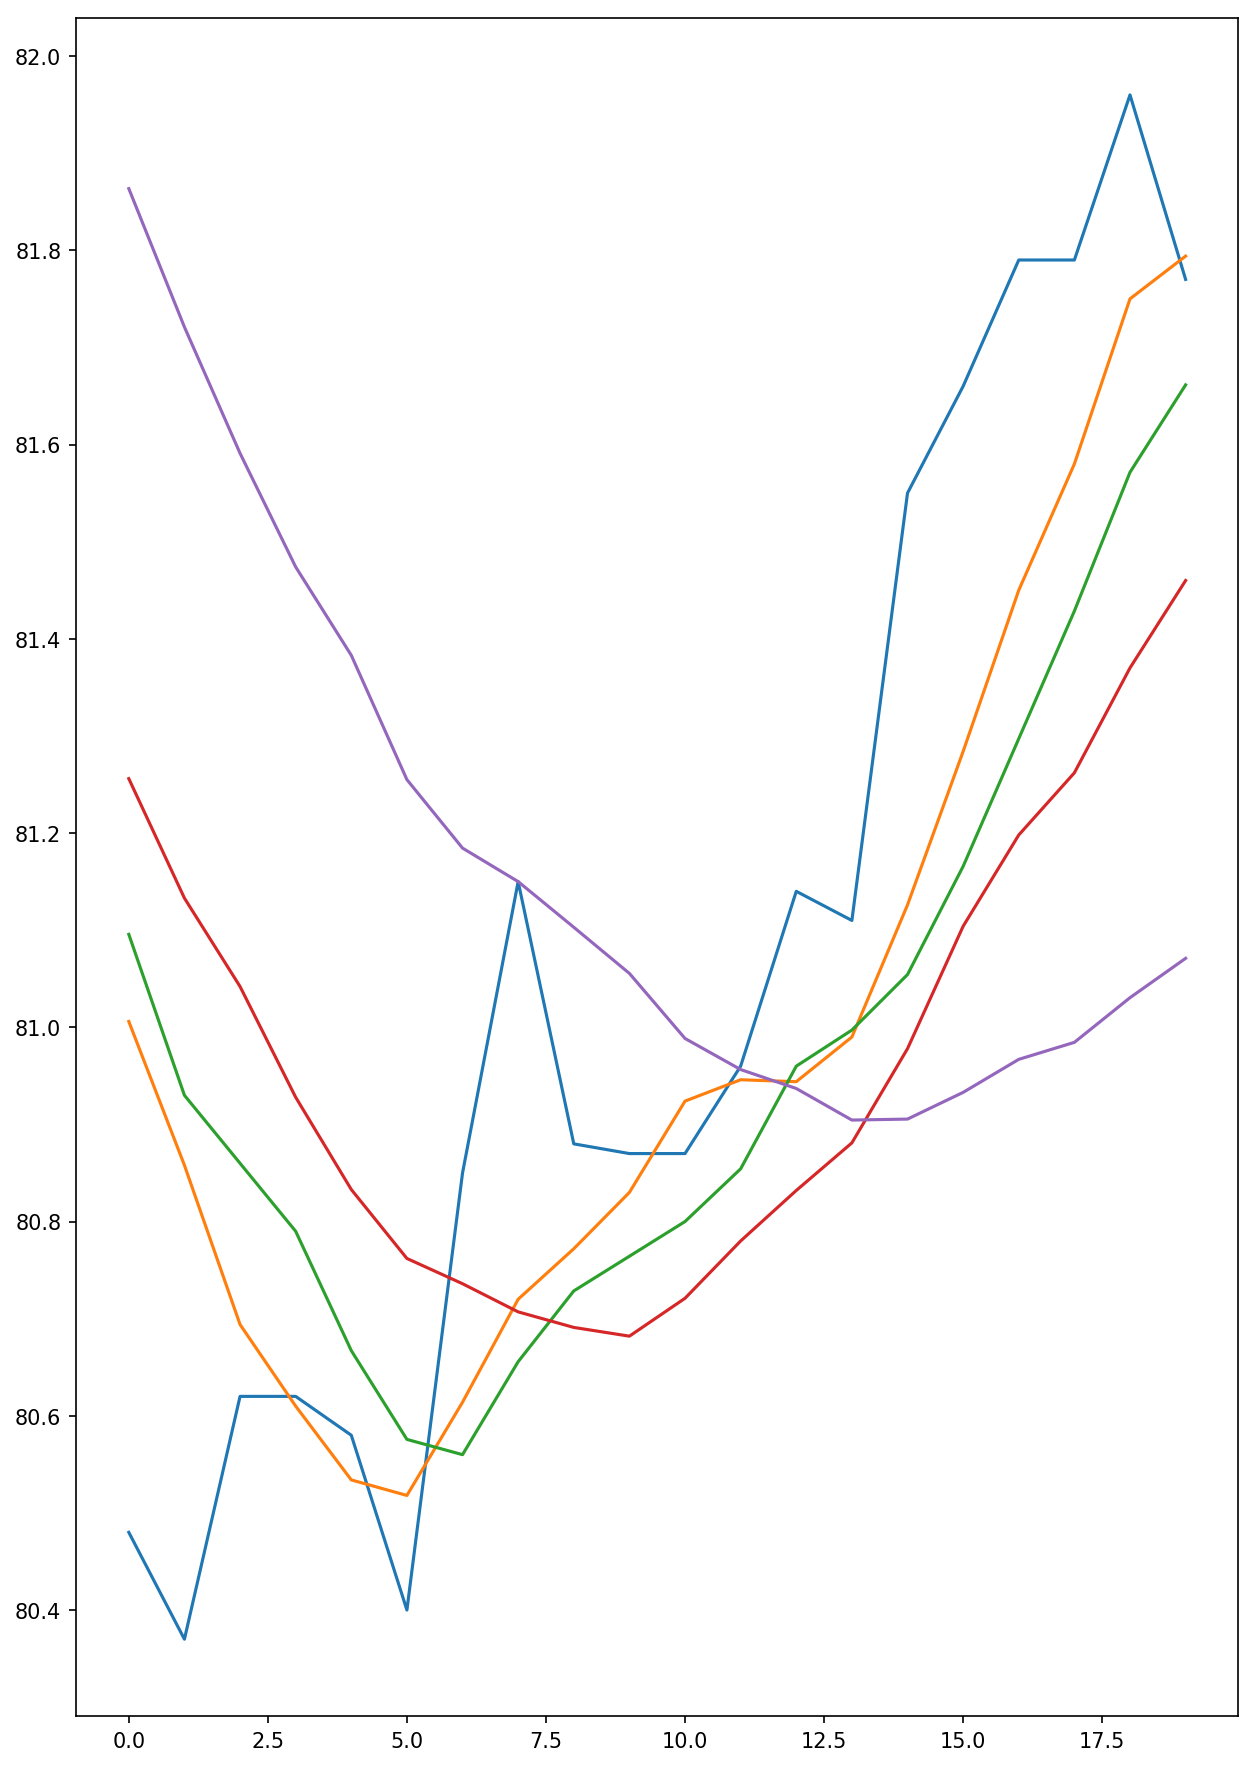

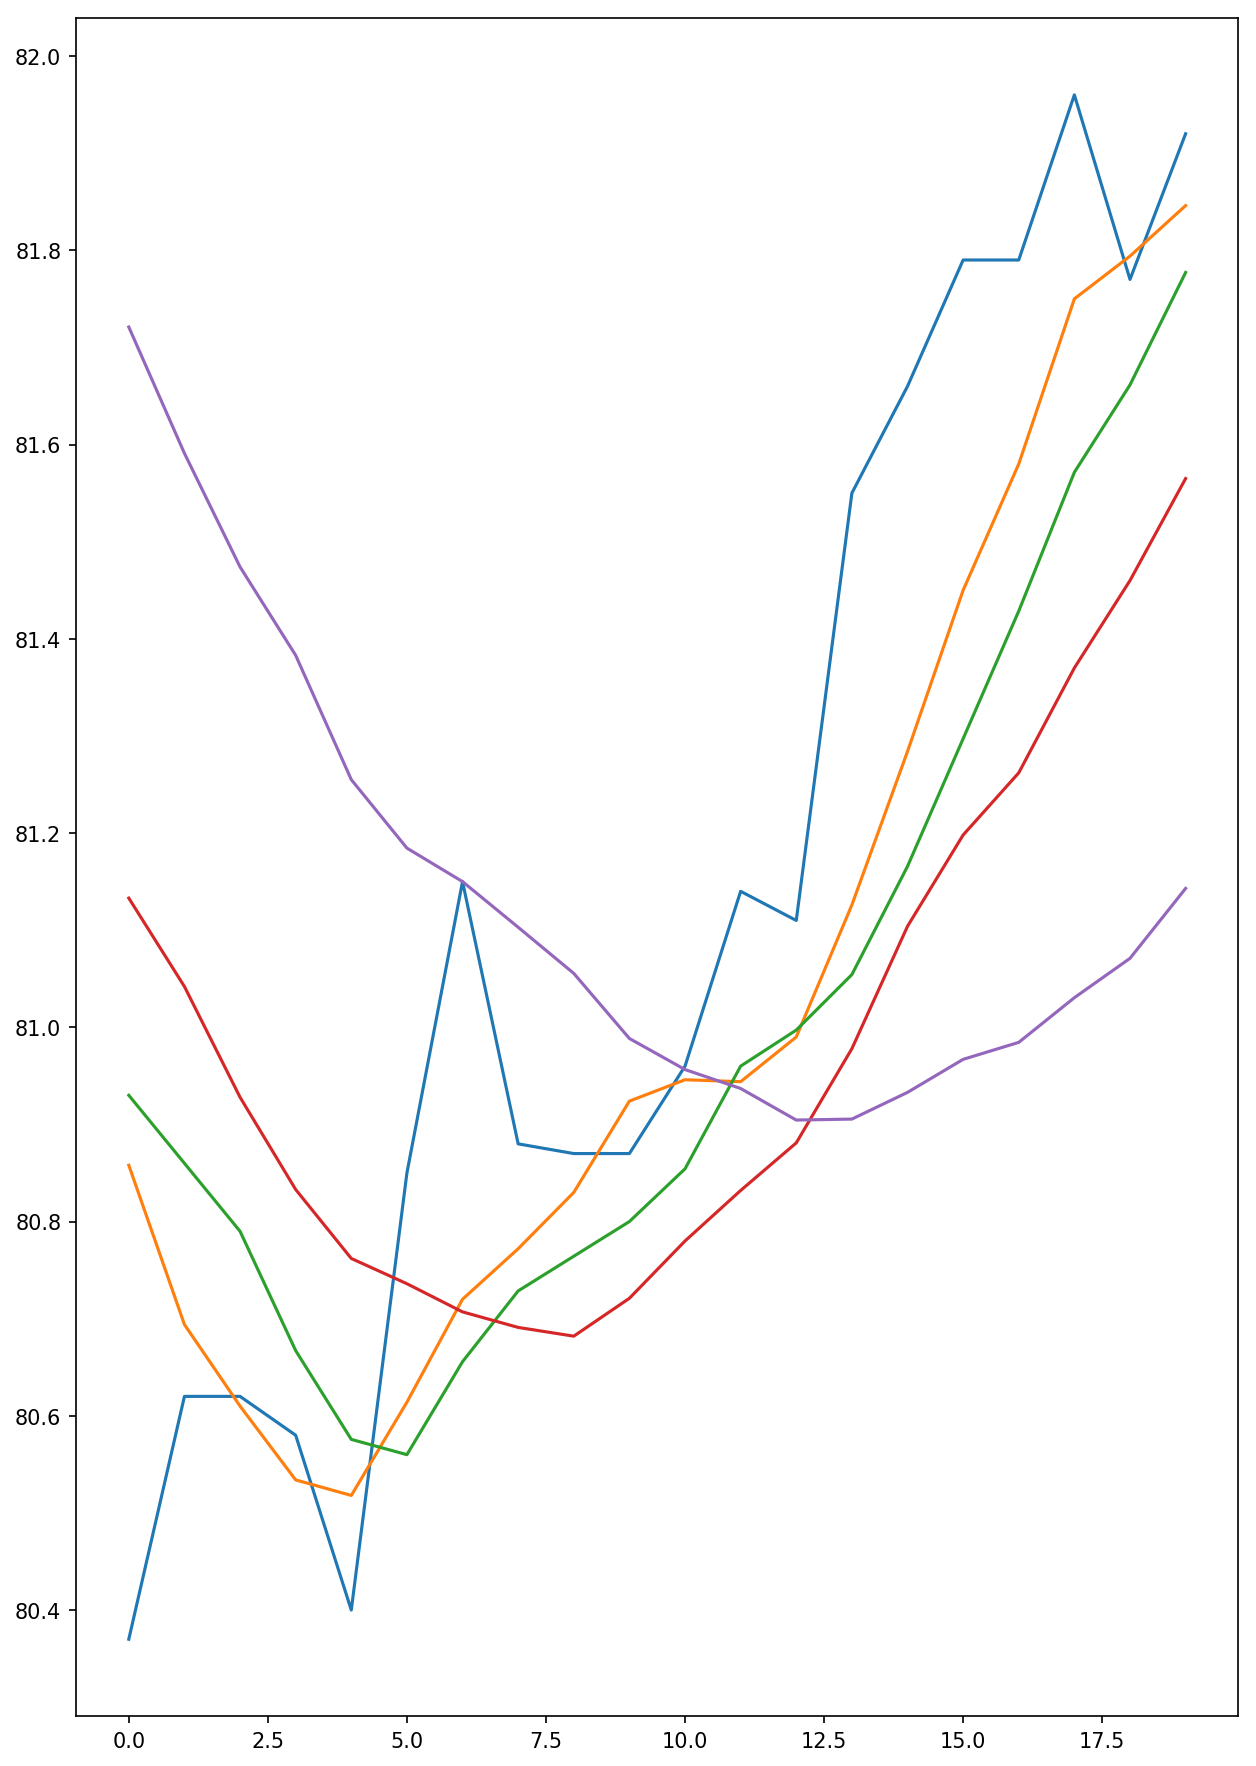

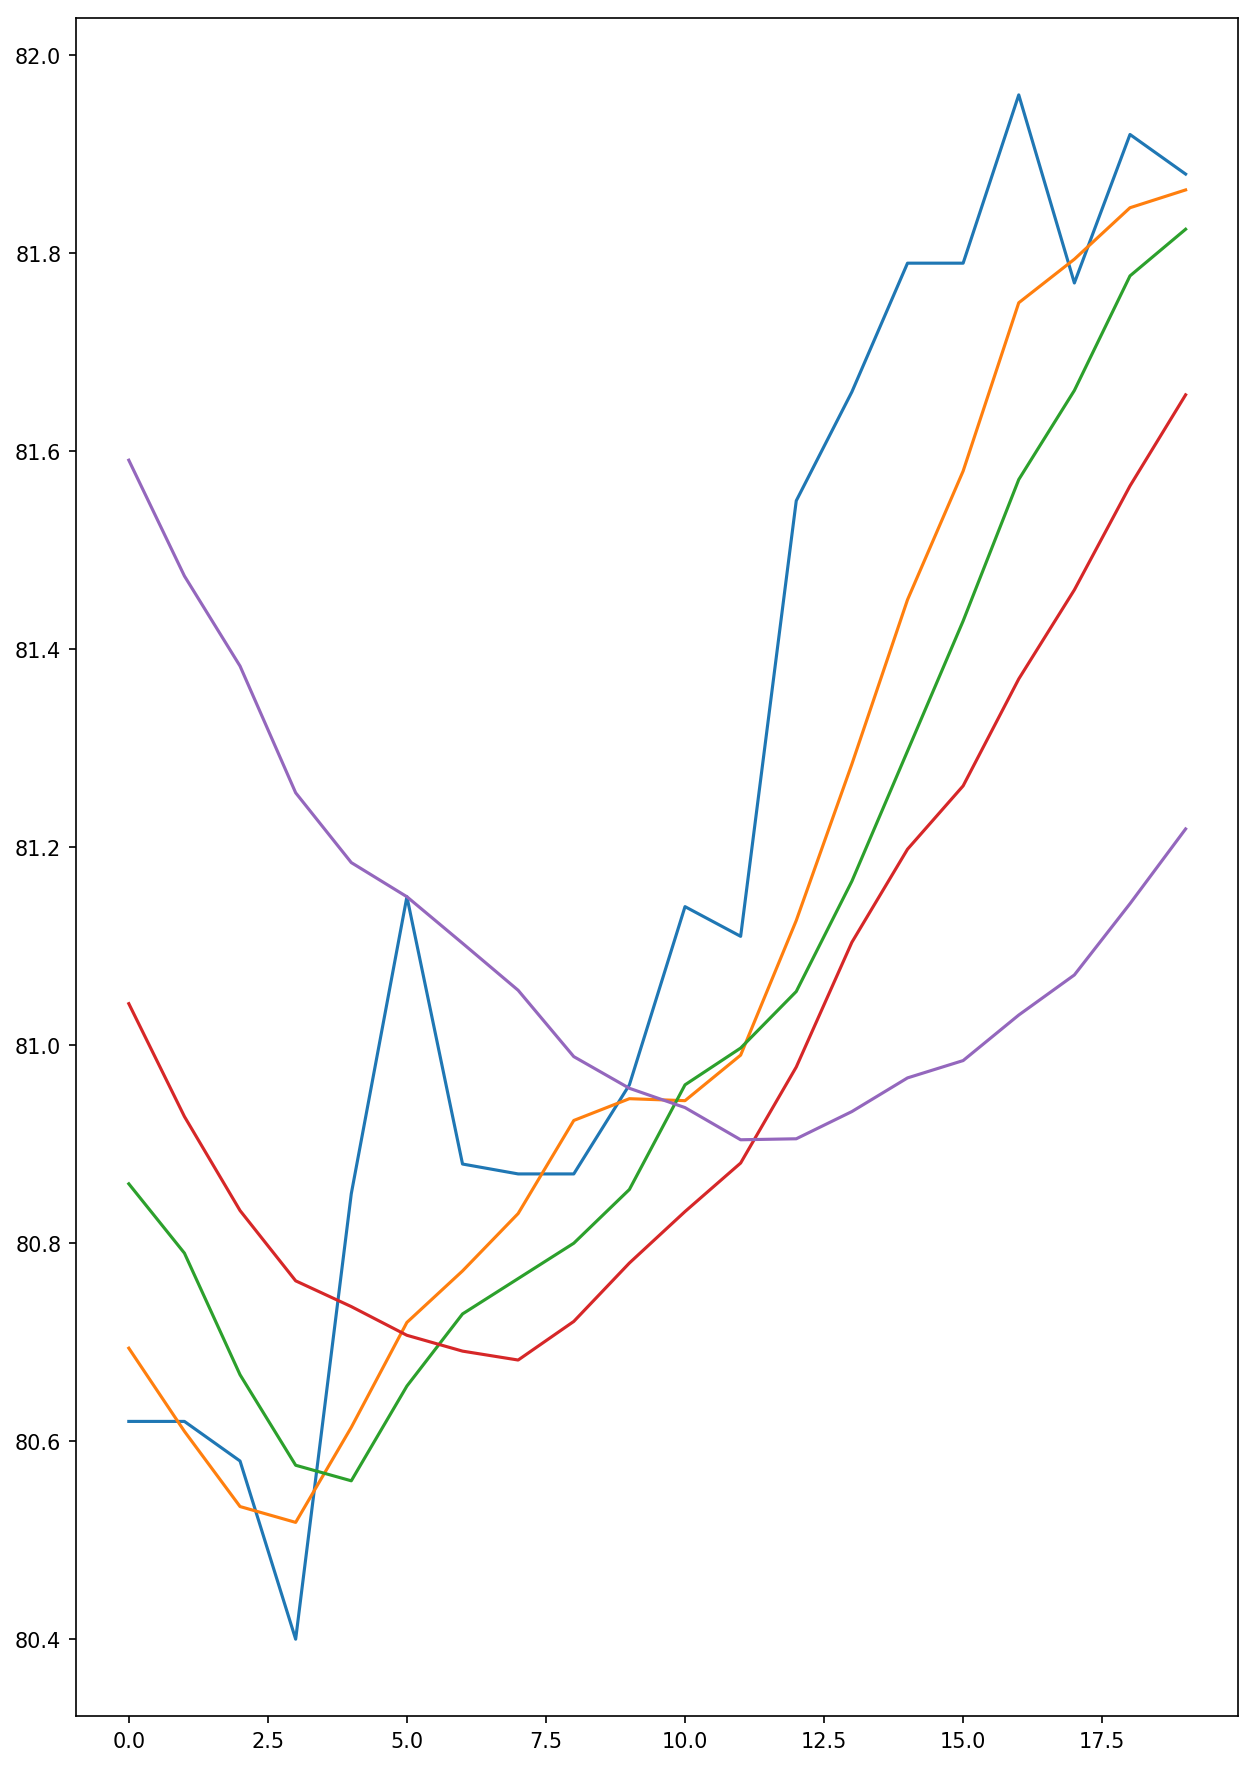

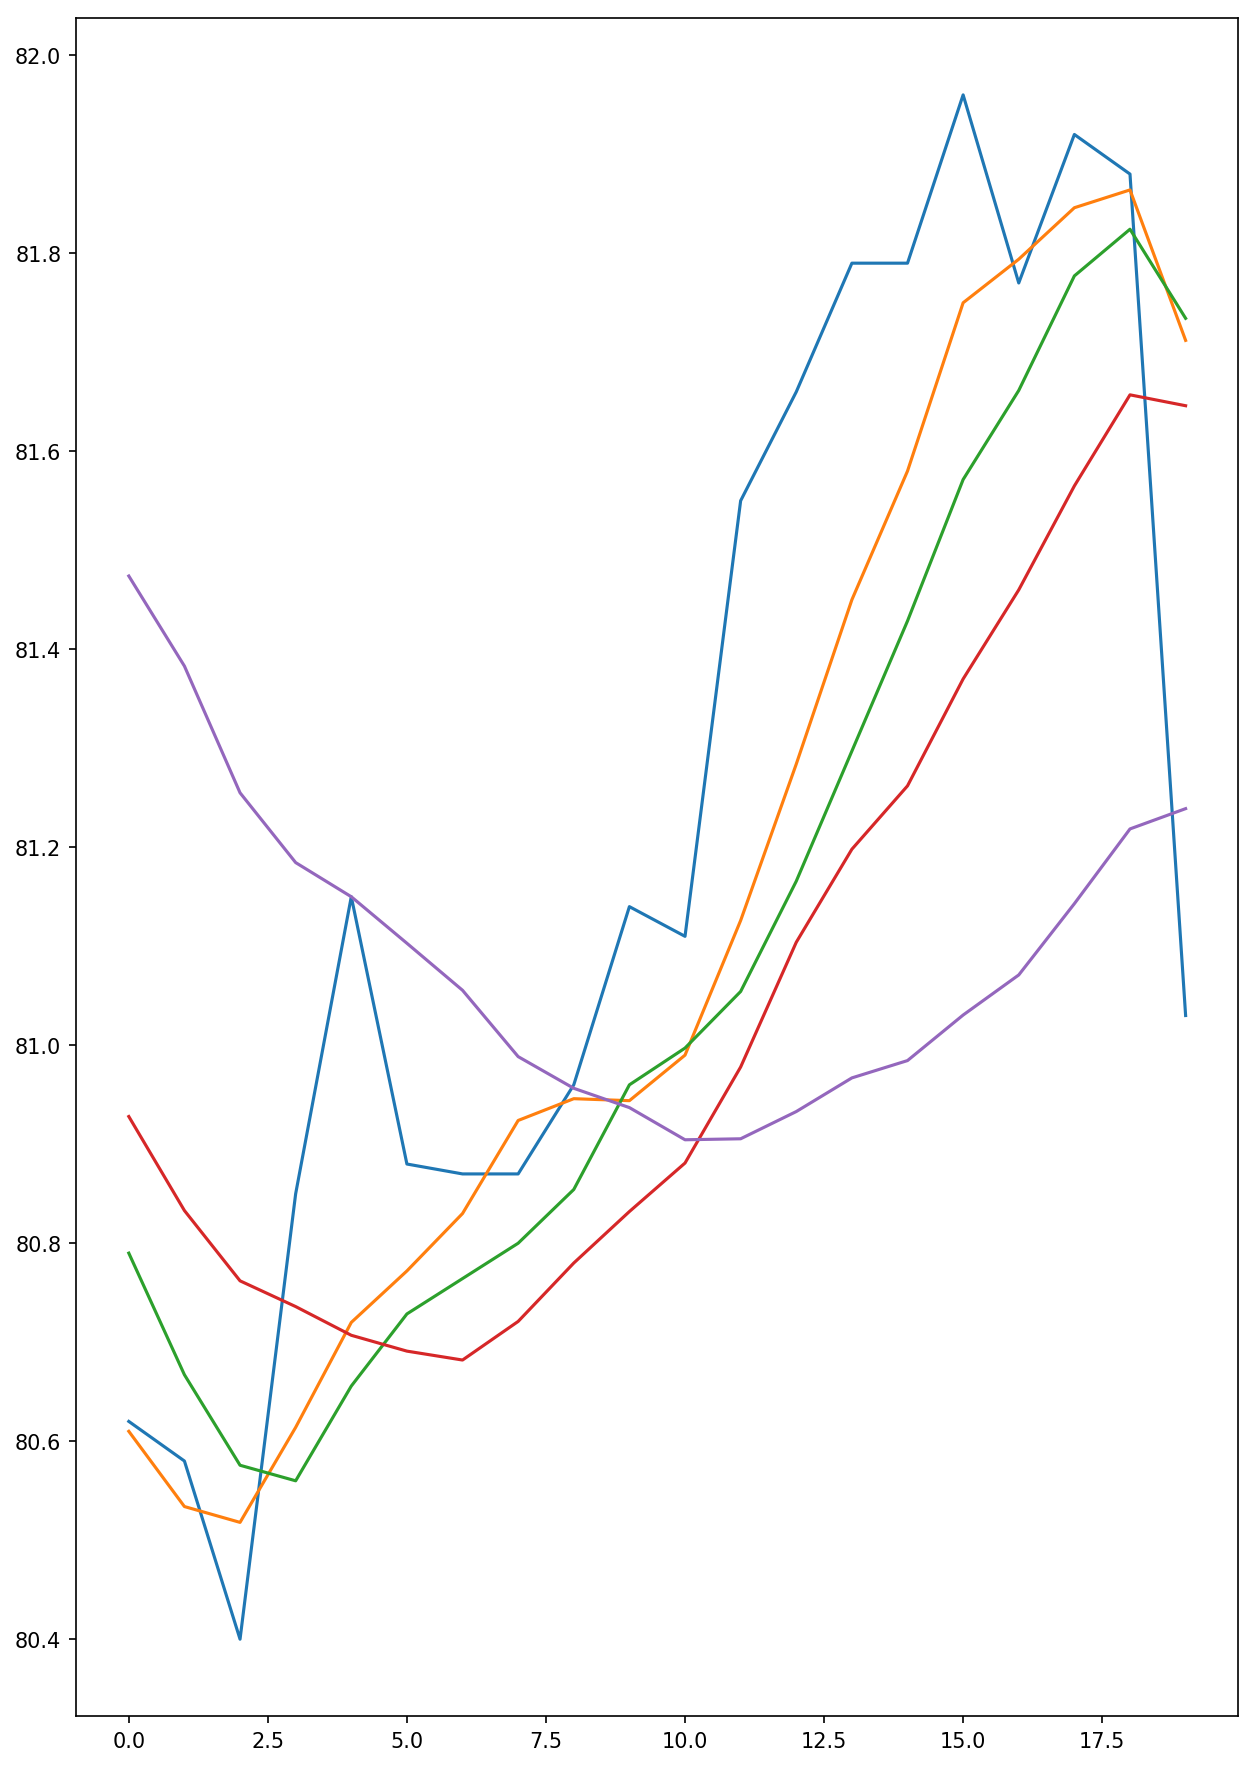

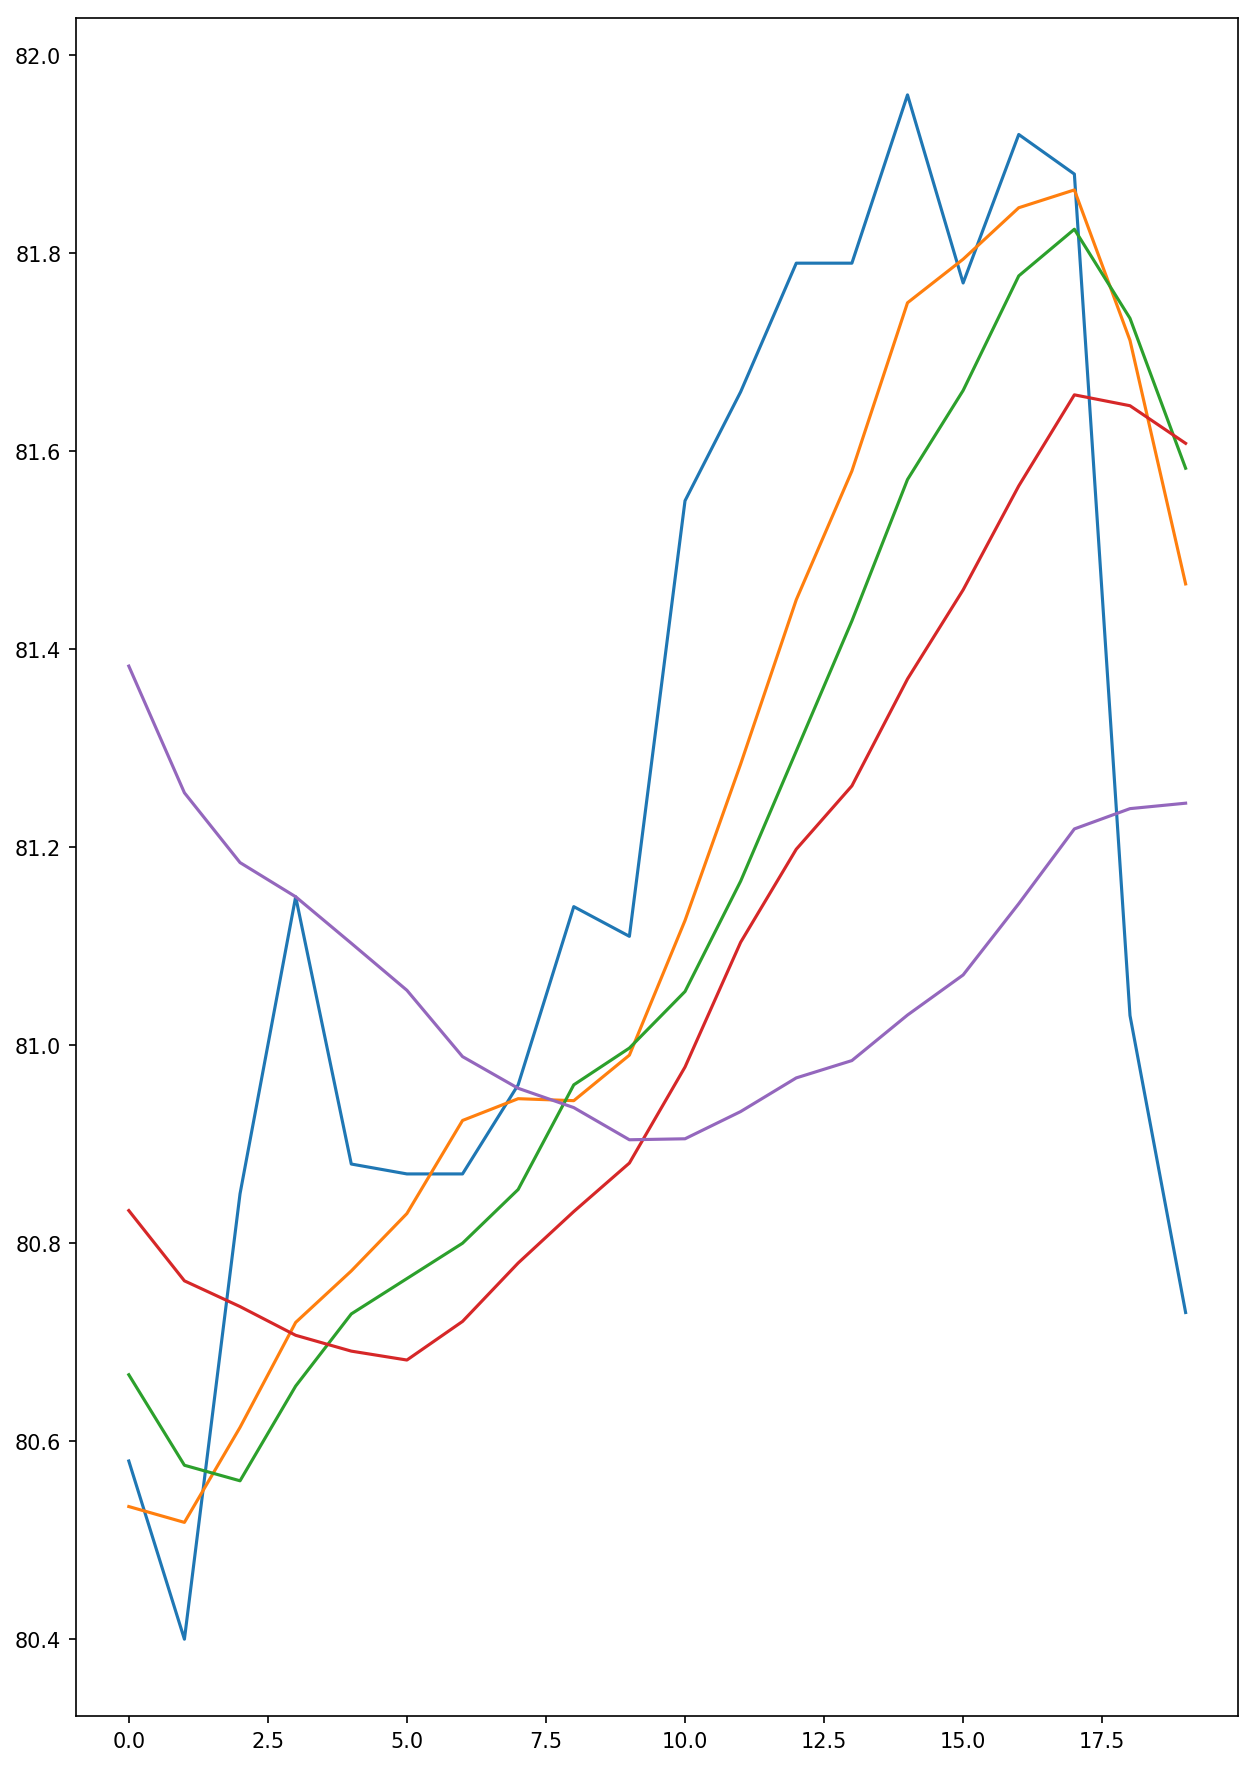

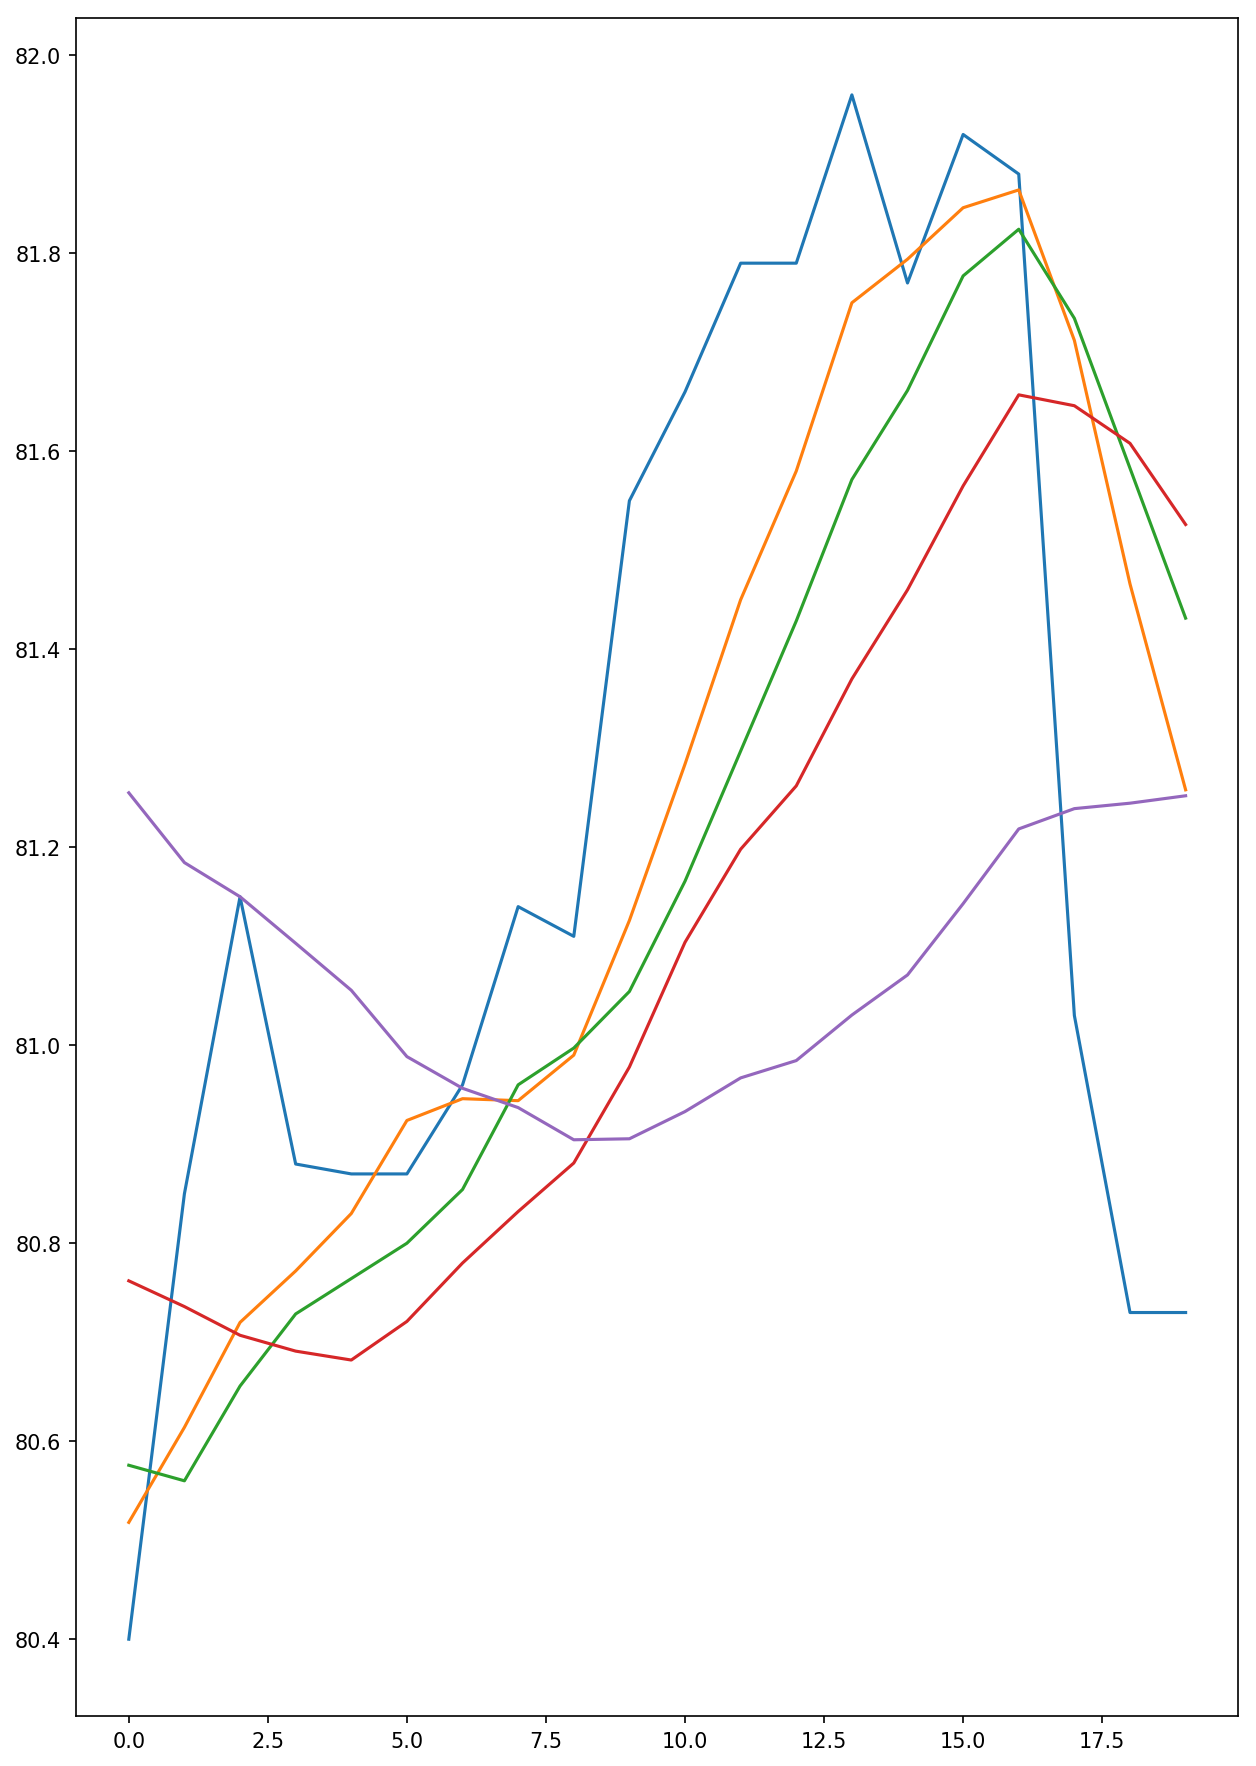

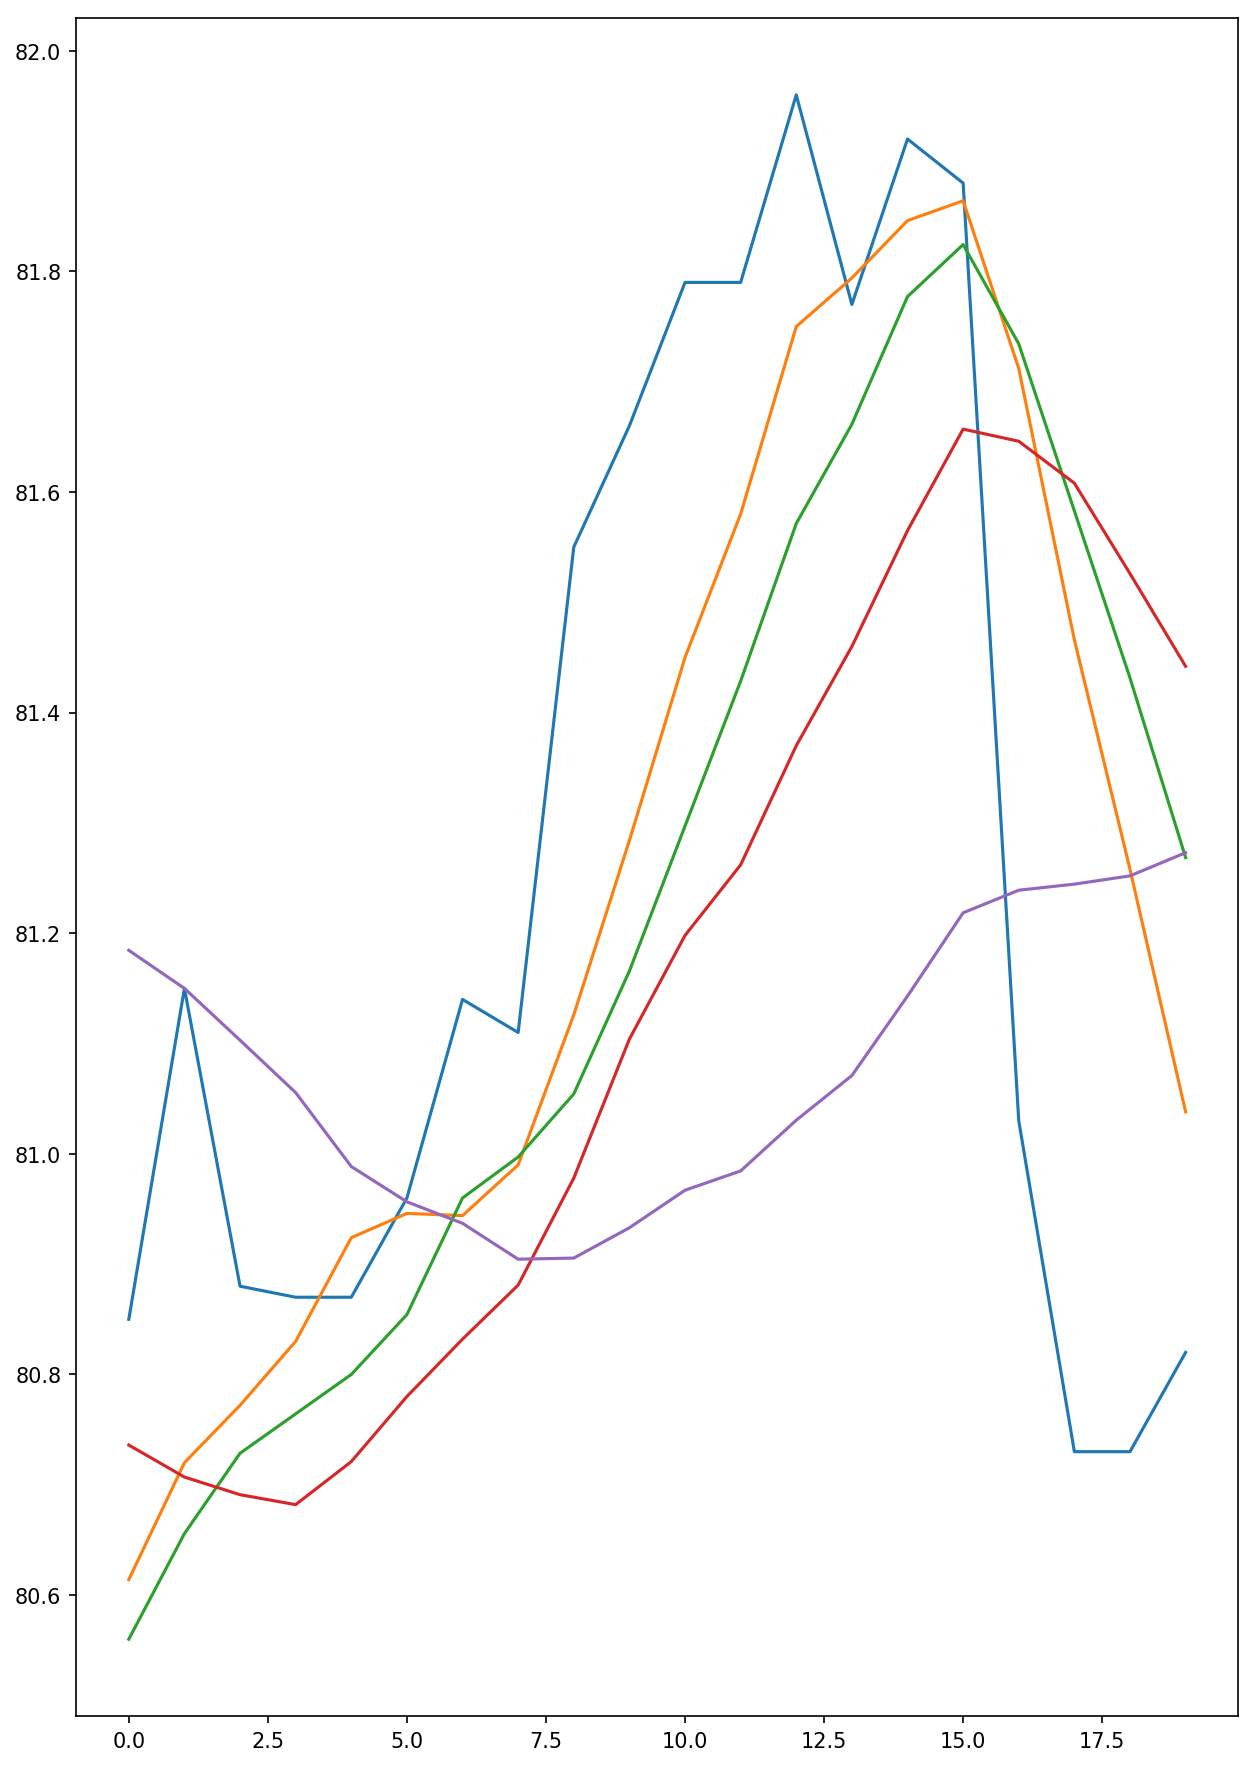

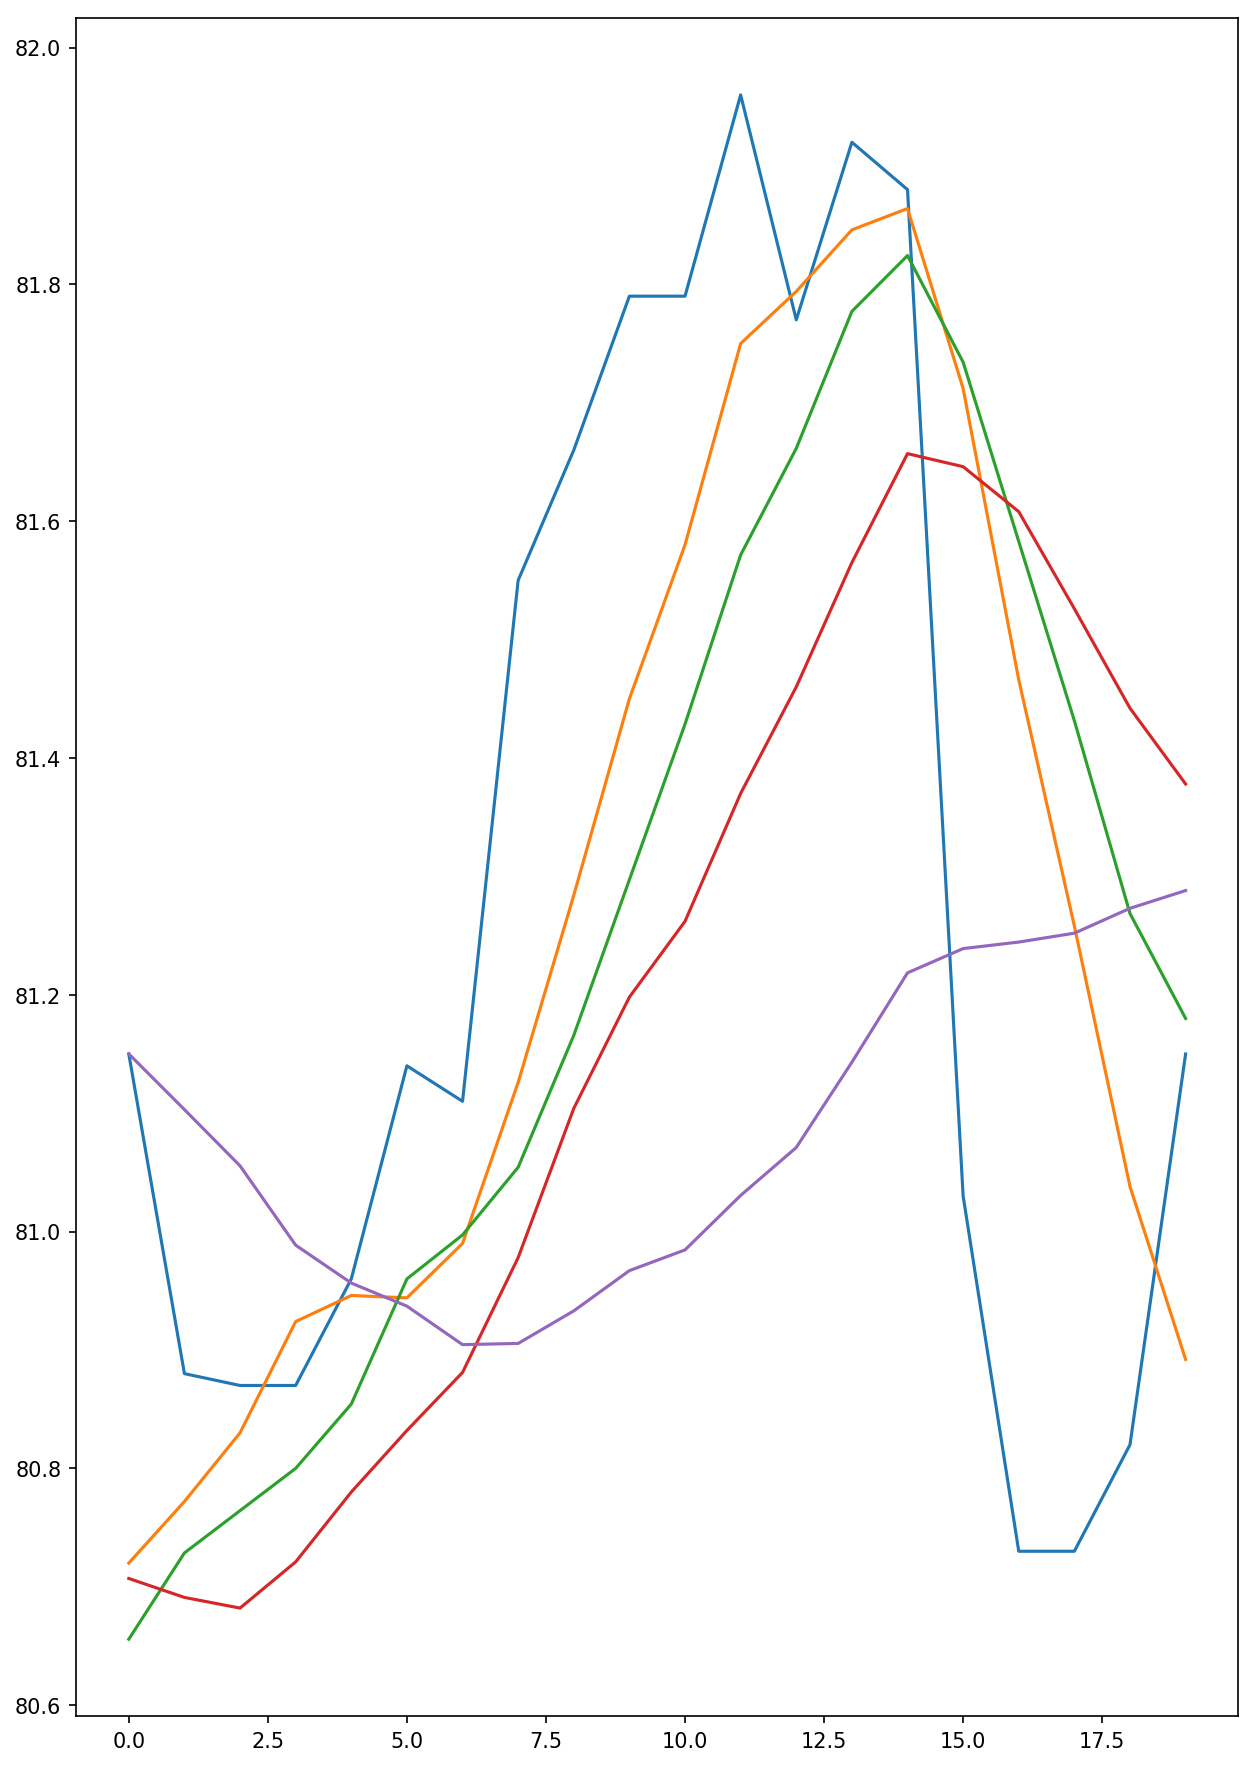

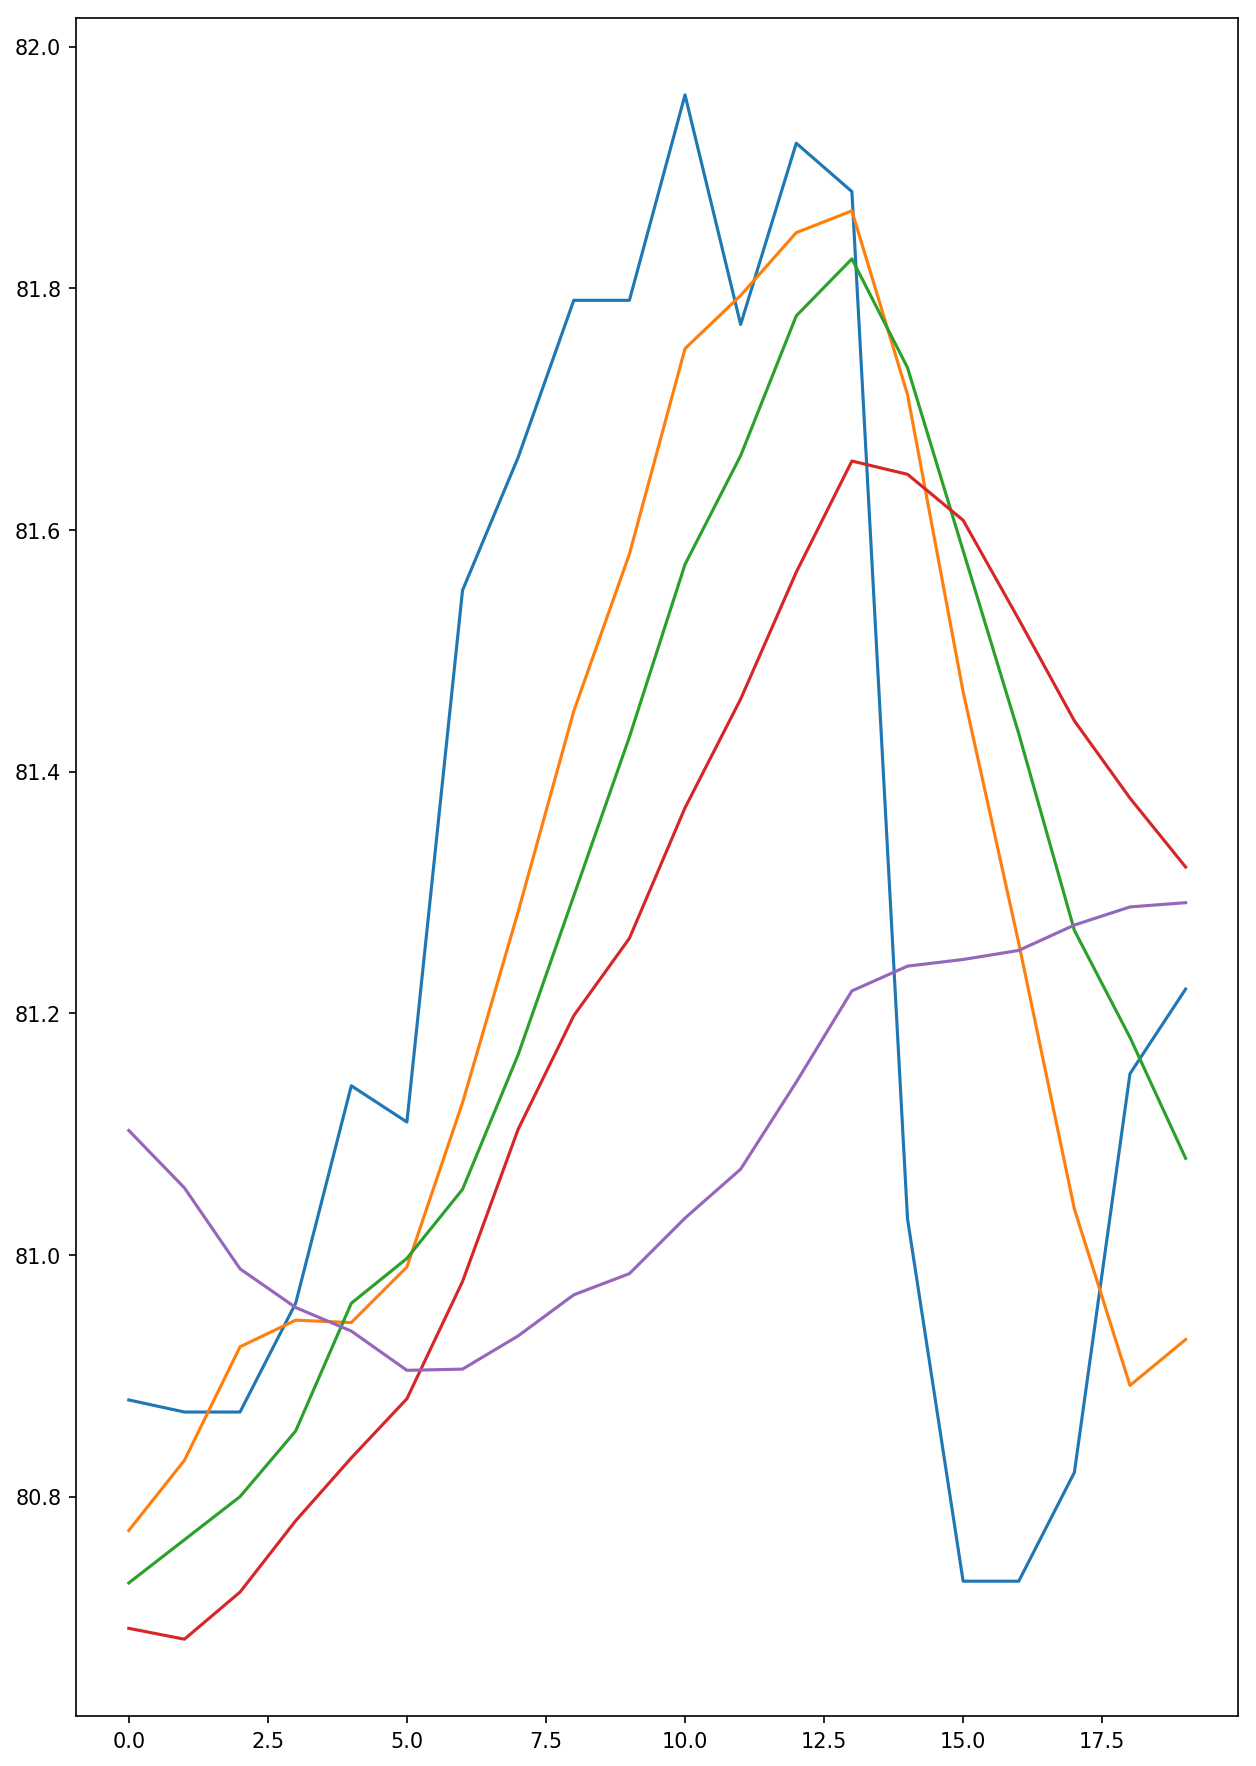

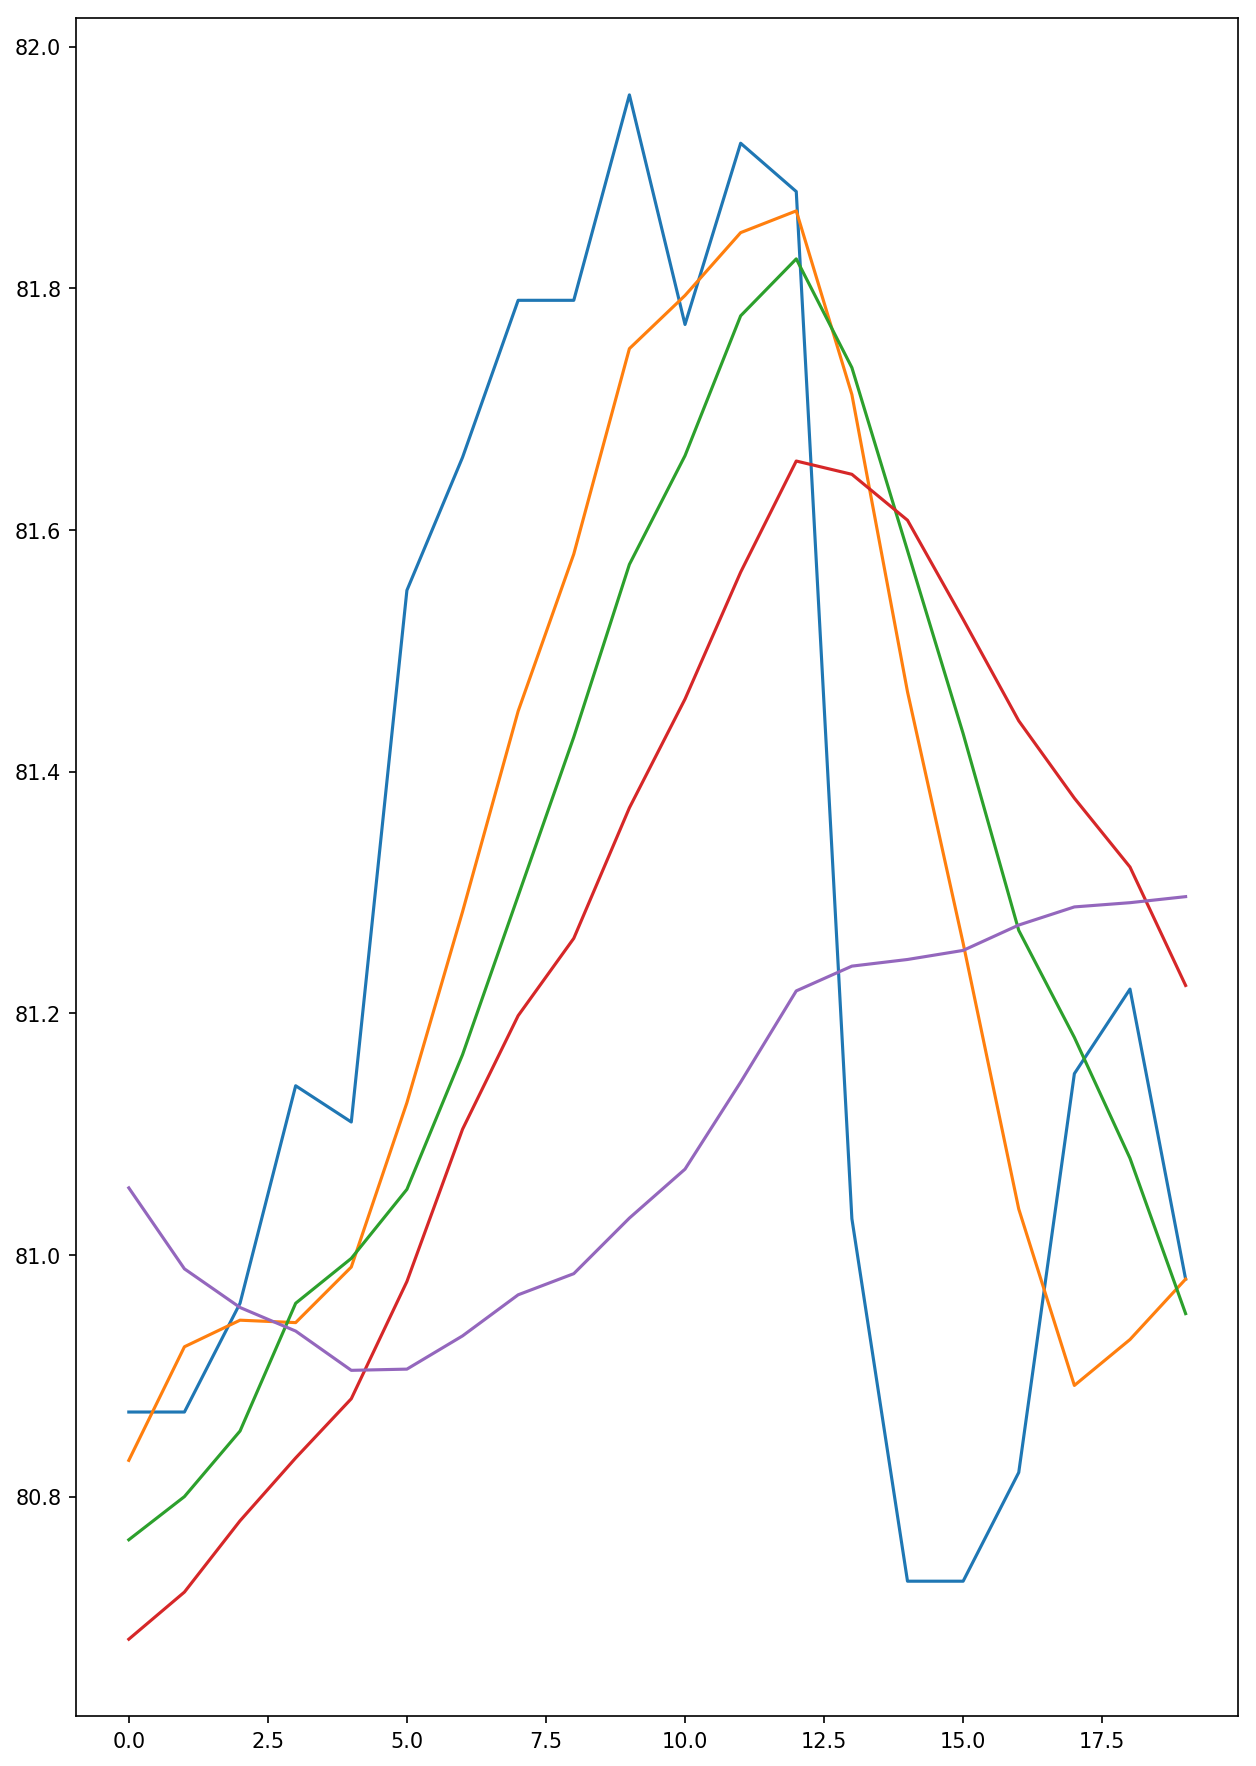

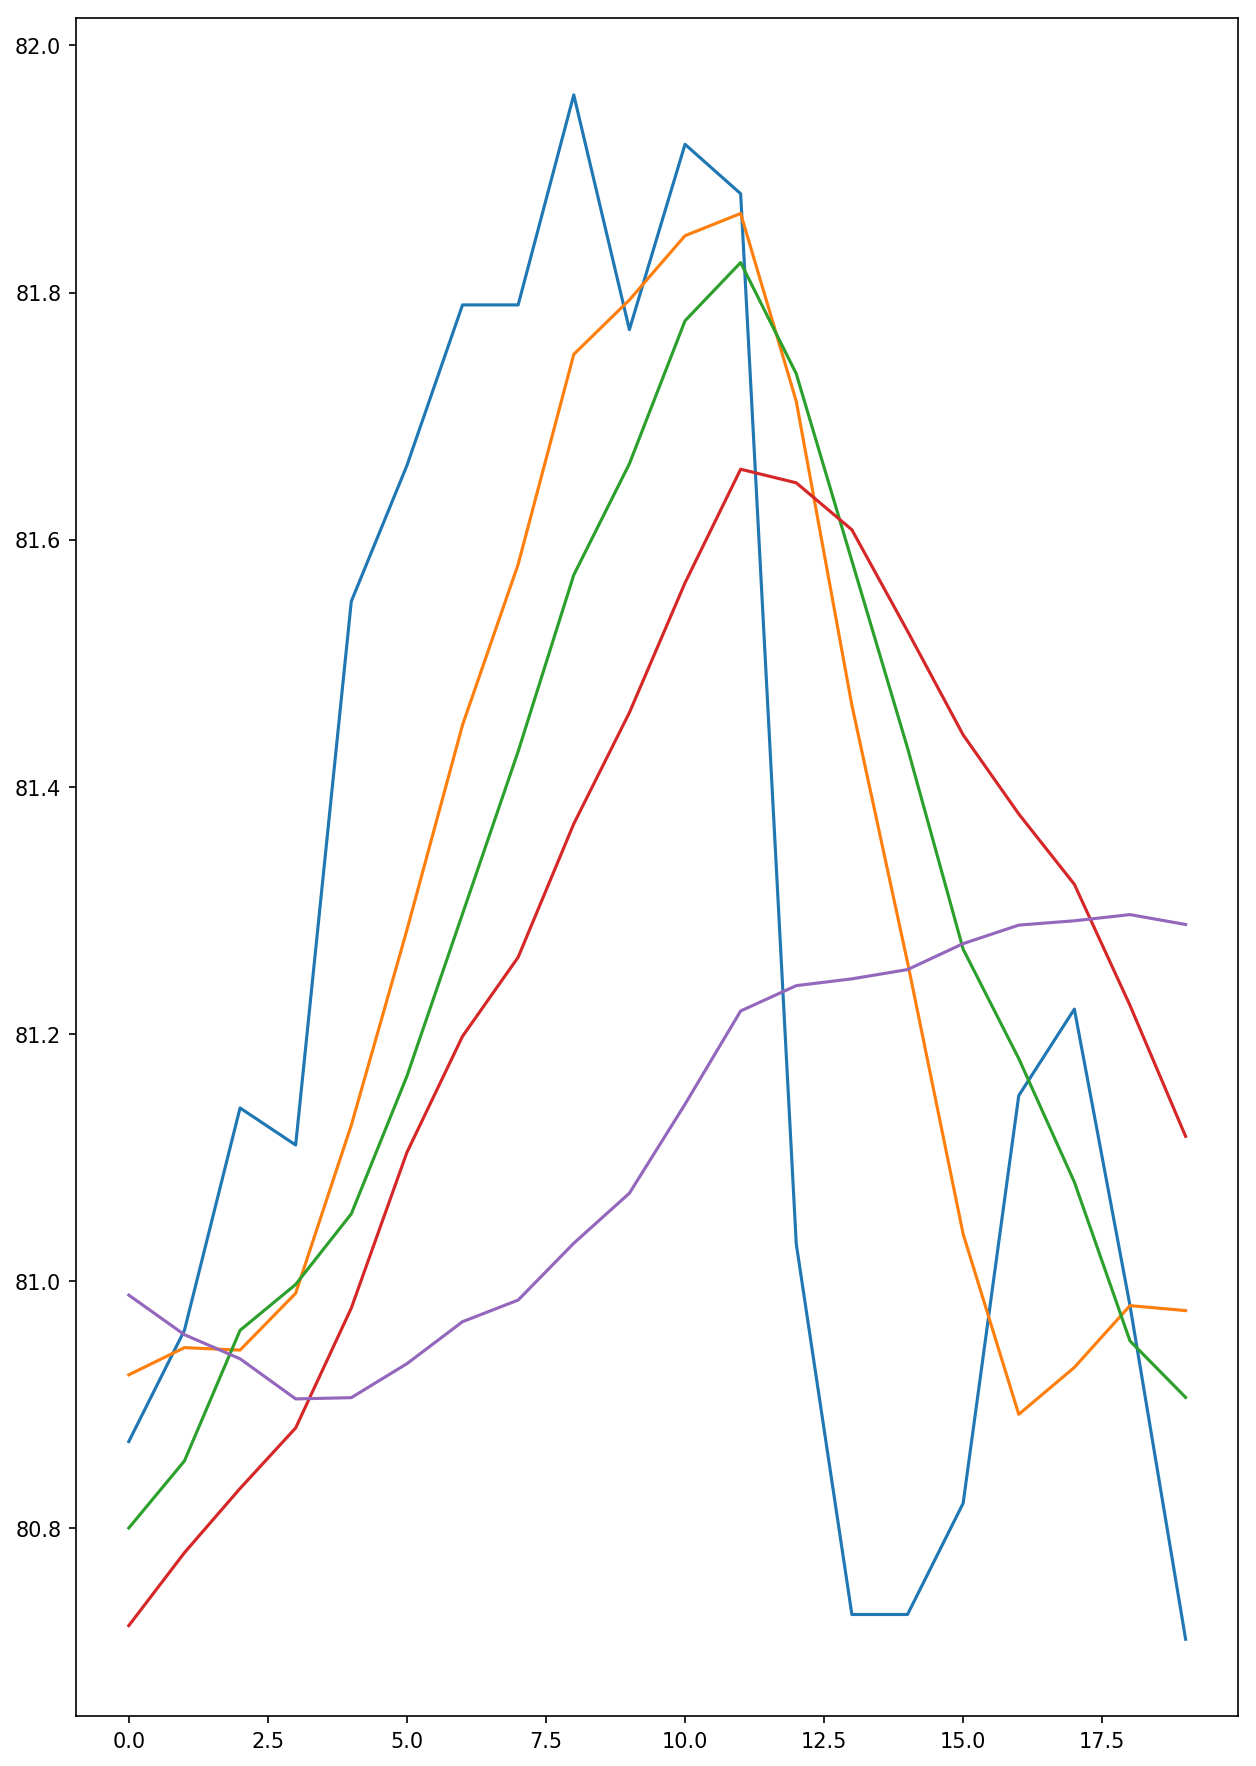

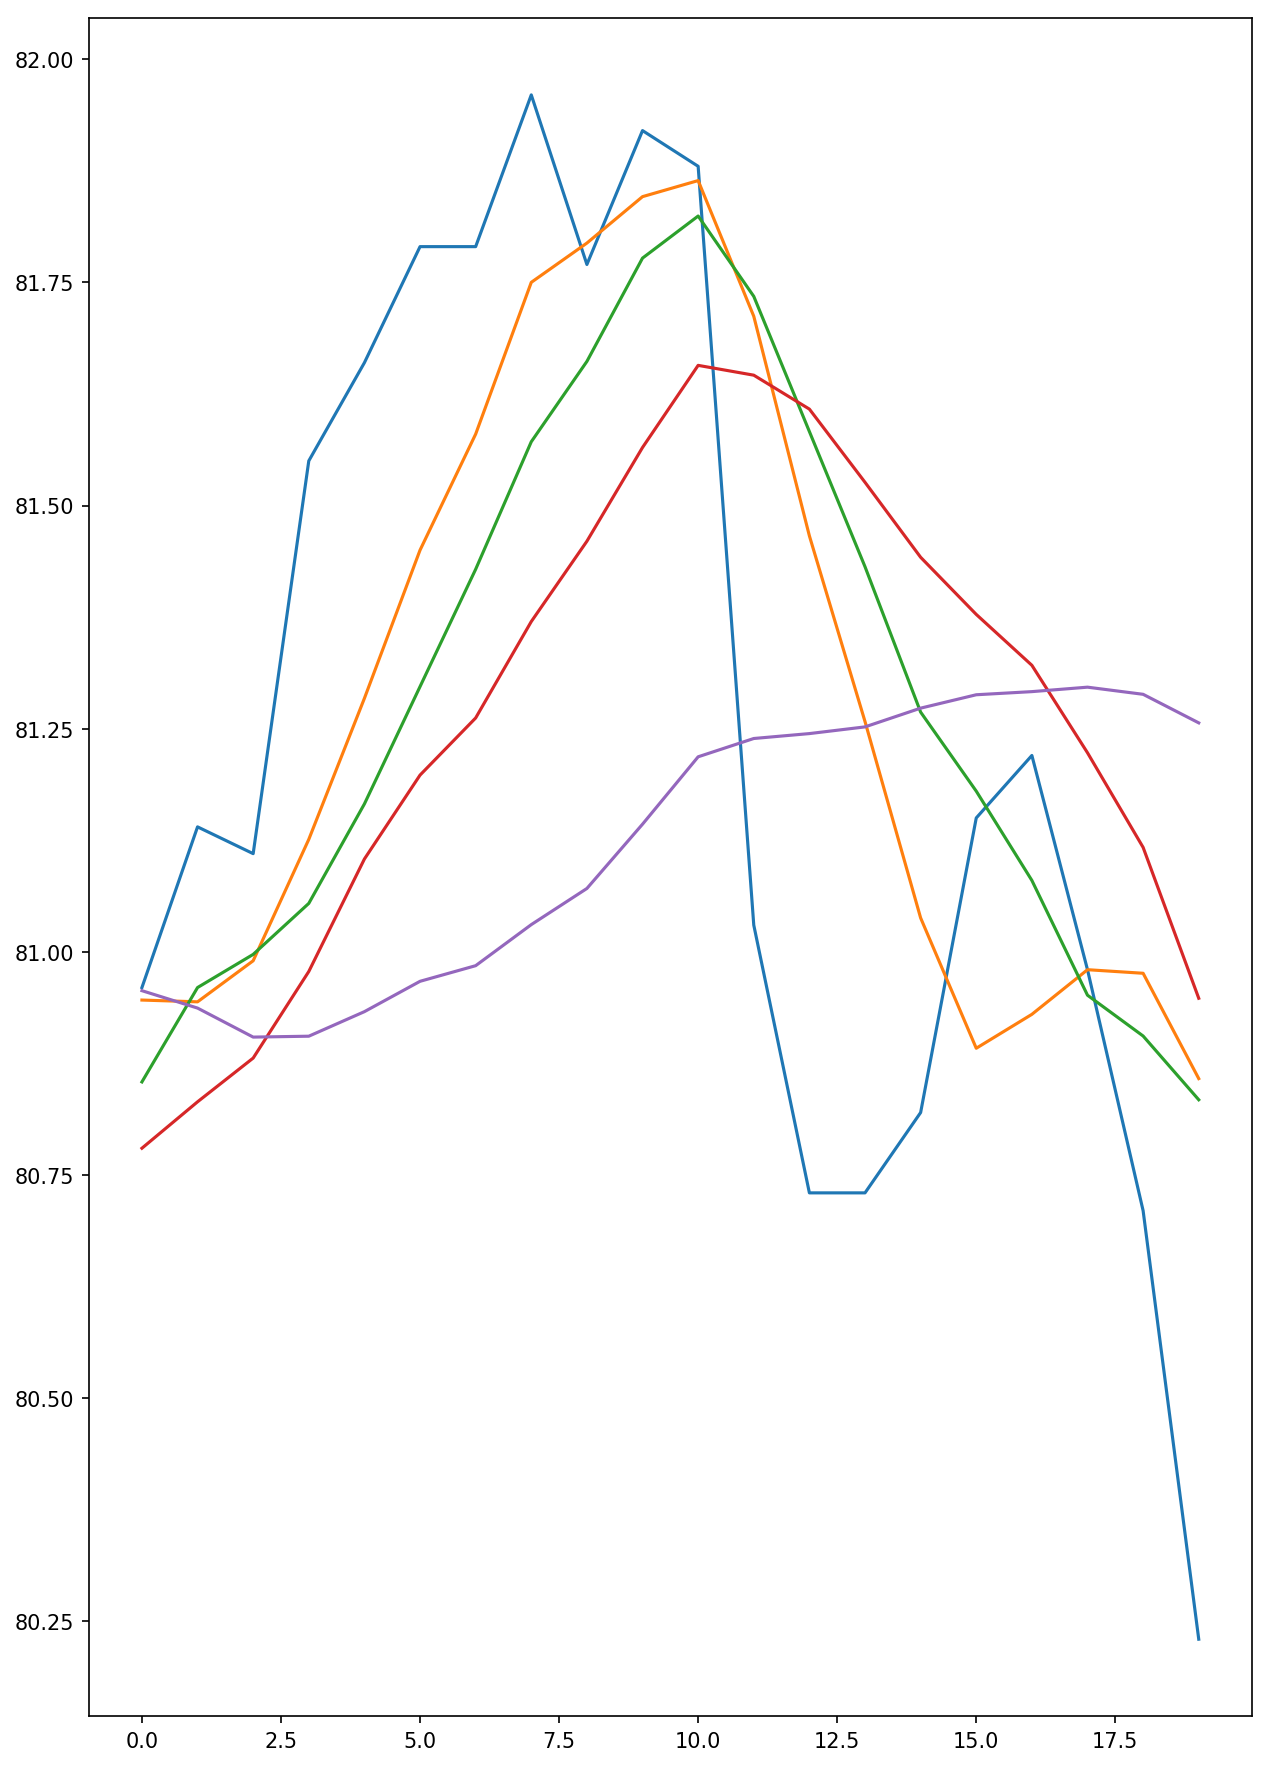

Error in callback <function flush_figures at 0x7f42716d0598> (for post_execute):


KeyboardInterrupt: 

In [11]:
#finging labels
buy = np.array([0,1])
sell = np.array([1,0])
hold = np.array([0,0])
for i in enumerate(data_chs):
    print(pct_chng(i[1][:,0][0],i[1][:,0][-1]))
    if pct_chng(i[1][:,0][0],i[1][:,0][-1]) >= 4:
        ch_df = pd.DataFrame(i[1])
        vis = data_vis(ch_df)
        plt.imsave(fname=data_path+'/buy/'+str(i[0])+'.png',arr=vis)
        
    if pct_chng(i[1][:,0][0],i[1][:,0][-1]) <= 4 :
        if pct_chng(i[1][:,0][0],i[1][:,0][-1]) <= -4:
            ch_df = pd.DataFrame(i[1])
            vis = data_vis(ch_df)
            plt.imsave(fname=data_path+'/sell/'+str(i[0])+'.png',arr=vis)
        else:
            ch_df = pd.DataFrame(i[1])
            vis = data_vis(ch_df)
            plt.imsave(fname=data_path+'/hold/'+str(i[0])+'.png',arr=vis)
    

In [15]:
#make validation and train splits
all_files = [i for i in gb(data_path+'/*/*')]
n_samples = len(all_files)
n_train = (0.9*n_samples)//3#number of images for training per each label
n_valid = (0.1*n_samples)//3#number of images for validation per each label


print('number of all images:',n_samples)
print('train each label images:',n_train)
print('validation each label images:',n_valid)


number of all images: 343
train each label images: 102.0
validation each label images: 11.0


In [ ]:


#make data generators
gen = ImageDataGenerator()
gen_f = gen.flow_from_directory()

/home/mohammad/anaconda3/envs/trading_network/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


In [2]:
gen = ImageDataGenerator()
gen_f = 

In [3]:
dir(gen)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_validation_split',
 'apply_transform',
 'brightness_range',
 'channel_axis',
 'channel_shift_range',
 'col_axis',
 'cval',
 'data_format',
 'dtype',
 'featurewise_center',
 'featurewise_std_normalization',
 'fill_mode',
 'fit',
 'flow',
 'flow_from_dataframe',
 'flow_from_directory',
 'get_random_transform',
 'height_shift_range',
 'horizontal_flip',
 'interpolation_order',
 'mean',
 'preprocessing_function',
 'principal_components',
 'random_transform',
 'rescale',
 'rotation_range',
 'row_axis',
 'samplewise_center',
 'samplewise_std_normalization',
 'shear_range',
 'standardize',
 'std',
 'vertical_flip',
 'width_shi